# Visual Inspection of Motorcycle Connecting Rods
The following work accomplishes the specifics of the **Visual Inspection of Motorcycle Connecting Rods** project. The aim of the project consists in extracting from some images information about the connecting rods, which are:
1. Type of rod (A or B)
2. Position and orientation
3. Length (L), Width (W) and Width at the barycenter (W_b)
4. For each hole, position of the centre and diameter size

The implementation of the previous features were part of the first task; for the second task I extended the project including images with distractors (point 1) and images with the presence of scattered iron powder (point 3)

Below there are the libraries imported in the project, all the functions and constants used and then all the steps of my implementation of these tasks. At each step more insights will be provided to explain the strategies and the algorithms used.

### Import libraries
Libraries used:
1. OpenCV
2. NumPy
3. Matplotlib
4. Math

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline

### Functions and constants
Below there are the functions and the constants with some comments that explain their use and meaning. 

In [2]:
# connecting rods classification constants
NUM_HOLES_CONNECTING_ROD_A = 1
NUM_HOLES_CONNECTING_ROD_B = 2
TYPE_A_CONNECTING_ROD_LABEL = 'A'
TYPE_B_CONNECTING_ROD_LABEL = 'B'
NOT_A_CONNECTING_ROD_LABEL = 'OTHER'
HARALICK_CIRCULARITY_THRESHOLD = 3

# closing structuring element dimension
CLOSING_ELEMENT_KERNEL_DIM = (3, 3)

# median filter kernel size for impulse noise
MEDIAN_FILTER_KERNEL_SIZE = 3

# images to process
input_images_name = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'Tesi33.bmp',
                     'TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP', 
                     'TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']

# plot an image
def show_image(image, figure_size=(20, 10), linear_contrast_streching=False):
    if linear_contrast_streching:
        image = linear_contrast_stretching(image)
    # Display Image
    plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

# plot all the images received, apply linear contrast streching if 'linear_contrast_streching' = True
def show_images(images, images_name, linear_contrast_streching=False, figure_size=(10, 5)):
    for i, image in enumerate(images):
        print("Image: ", images_name[i], "\nShape: ", image.shape)
        show_image(image, figure_size, linear_contrast_streching)

def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

# apply linear contrast stretching to an image
def linear_contrast_stretching(image, max_grey_level = 255, min_grey_level = 0):
    max_level = np.max(image)
    min_level = np.min(image)
#     lut = np.array([0 if i < min_level or i > max_level 
#                     else normalize(i, min_level, max_level) * (max_grey_level) 
#                     for i in range(max_grey_level+1)]).astype('uint8')
    lut = np.array([0 if i < min_level or i > max_level 
                    else normalize(i, min_level, max_level) * (max_grey_level - min_grey_level) + min_grey_level
                    for i in range(max_grey_level+1)]).astype('uint8')
    return cv2.LUT(image, lut)

# load images with name in the list 'images_name' from the folder pointed by 'images_path'
def load_images(images_path, images_name):
    images = []
    for i, image_name in enumerate(images_name):    
        # read image
        image = cv2.imread(images_path + image_name, cv2.IMREAD_GRAYSCALE)
        images.append(image)
    return images

# compute histograms of a list of images. Print them if 'verbose' = True
def compute_histograms(images, images_name, verbose=True, figure_size=(10, 5)):
    histograms = []
    for i, image in enumerate(images):   
        # Extracting the histogram
        hist, bins = np.histogram(image.flatten(), 256, [0,256])
        histograms.append(hist)
        # Plotting the histogram before operator
        if verbose:
            plt.figure(figsize=figure_size)
            plt.title(images_name[i])
            plt.stem(hist, use_line_collection=True)
            plt.show()
    return histograms

# apply median filter with kernel size 'kernel_size' to 'images'
def apply_median_filter(images, kernel_size = 3, images_idx=None):
    # if images_idx is None, apply median filter to every images
    if images_idx is None:
        images_idx = range(0, len(images))
    for i in images_idx:    
        images[i] = cv2.medianBlur(images[i], kernel_size)
    return images

# apply image segmentation to the element of the list 'images' using the threshold computed with Otsu's algorithm
def binarize_images(images):
    binary_images = []
    for image in images:   
        threshold, binary_image = cv2.threshold(image, None, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        threshold = int(threshold)
        binary_images.append(binary_image)
    return binary_images

# perform closing (dilatation + erosion) on the element of the list 'images' using a kernel 
# with dimension 'kernel_dim'
def close_images(images, kernel_dim=(3, 3)):
    closed_images = []
    kernel = np.ones(kernel_dim, np.uint8)
    for image in images:
        closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        closed_images.append(closed_image)
    return closed_images

# identify connected components in the elements of the list 'binary_images' and apply labeling
def compute_connected_components(binary_images):
    labeled_images = []
    images_stats = []
    num_connected_components = []
    images_centroids = []
    for image in binary_images:
        retval, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(image, 8, cv2.CV_8U, cv2.CCL_DEFAULT)
        labeled_image = labeled_image.astype('uint8')
        labeled_images.append(labeled_image)
        images_stats.append(stats)
        num_connected_components.append(retval)
        images_centroids.append(centroids)
    return num_connected_components, labeled_images, images_stats, images_centroids

# return a new image where all the pixel in 'labeled_image' with gray level != 'label' will be transformed to 0,
# so only those = 'label' will compose the foreground
def get_masked_image_given_label(labeled_image, label):
    return np.array([[int(gray_level == label) for gray_level in row] for row in labeled_image]).astype('uint8')

# compute the contour of each connected components of each image in 'labeled_image' whose label is in 'labels'
def compute_connecting_rods_contours(labeled_images, labels):
    connecting_rods_contours = []
    for i, labeled_image in enumerate(labeled_images):
        connecting_rods_contours_per_image = []
        for label in labels[i]:
            masked_image = get_masked_image_given_label(labeled_image, label)
            contours, _ = cv2.findContours(masked_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            connecting_rods_contours_per_image.append(contours)
        connecting_rods_contours.append(connecting_rods_contours_per_image)
    return connecting_rods_contours

# Haralick circularity is the mean of the distances of the contour pixels from the centre 
# divided by their standard deviation
def compute_haralick_circularity(centre, contour):
    distances = []
    for point in contour:
        euclidean_distance = np.linalg.norm(point - centre)
        distances.append(euclidean_distance)
    mean = np.mean(distances)
    std = np.std(distances)
    return mean / std

# used for debugging and for showing results: for each connected component in each image of 'labeled_images' 
# print the related information stored in 'data' 
def show_connected_components(labeled_images, labels, images_name, data, title, caption):
    print(title)
    for i, labeled_image in enumerate(labeled_images):
        print("Image: ", images_name[i])
        for j in range(len(data[i])):
            masked_image = get_masked_image_given_label(labeled_image, labels[i][j])
            print(caption, data[i][j])
            show_image(linear_contrast_stretching(masked_image), (10, 5))

# classify each connected components counting the holes of the item and computing the Haralick's circularity.
# The types are 3:
# 1) connecting rods type A (2 holes)
# 2) connecting rods type B (1 holes)
# 3) not a connecting rods (items that have 0 or more than 2 holes and items that have a circle shape)
def classify_connecting_rods(connecting_rods_contours, connecting_rods_centroids):
    connecting_rods_type = []
    for i in range(len(connecting_rods_contours)):
        connecting_rods_type_per_image = []
        for j in range(len(connecting_rods_contours[i])):
            contours = connecting_rods_contours[i][j]
            # Define the 2 features: num_holes and haralick_circularity
            num_holes = len(contours) - 1
            haralick_circularity = compute_haralick_circularity(connecting_rods_centroids[i][j], 
                                                                np.squeeze(contours[0]))
            # Connecting rods seems to have haralick circularity close to 2, 
            # so if it is above HARALICK_CIRCULARITY_THRESHOLD, the the inspected item shouldn't be a connecting rod
            if haralick_circularity > HARALICK_CIRCULARITY_THRESHOLD:
                connecting_rod_type = NOT_A_CONNECTING_ROD_LABEL  
            elif num_holes == NUM_HOLES_CONNECTING_ROD_A:
                connecting_rod_type = TYPE_A_CONNECTING_ROD_LABEL 
            elif num_holes == NUM_HOLES_CONNECTING_ROD_B: 
                connecting_rod_type = TYPE_B_CONNECTING_ROD_LABEL
            else:
                connecting_rod_type = NOT_A_CONNECTING_ROD_LABEL
            connecting_rods_type_per_image.append(connecting_rod_type)
        connecting_rods_type.append(connecting_rods_type_per_image)
    return connecting_rods_type

# extract connecting rod position information from the output of the connecting components procedure
def get_connecting_rods_position(labels, centroids, stats):
    connecting_rods_position = []
    for i in range(len(images)):
        connecting_rods_position_per_image = []
        for j in range(len(labels[i])):
            position = {"centroid": (int(centroids[i][j][0]), int(centroids[i][j][1])), "leftmost_x": stats[i][j][0], "topmost_y": stats[i][j][1], 
                        "width": stats[i][j][2], "height": stats[i][j][3]}
            connecting_rods_position_per_image.append(position)
        connecting_rods_position.append(connecting_rods_position_per_image)
    return connecting_rods_position

# compute the orientation of the connecting rods respect to the horizontal axis
def compute_connecting_rods_orientation(connecting_rods_contours):
    connecting_rods_orientation = []
    for i in range(len(connecting_rods_contours)):
        connecting_rods_orientation_per_image = []
        for j in range(len(connecting_rods_contours[i])):
            (_, _), (_, _), angle = cv2.fitEllipse(connecting_rods_contours[i][j][0])
            connecting_rods_orientation_per_image.append(angle)
        connecting_rods_orientation.append(connecting_rods_orientation_per_image)
    return connecting_rods_orientation

# given the contour of a single connecting rod, return its length and width
def extract_connecting_rod_length_and_width(connecting_rod_contour):
    # computing the minimum oriented enclising rectangle
    (_, _), dimensions, _ = cv2.minAreaRect(connecting_rod_contour)
    # knowing the shape of a connecting rod, the longest dimension is the length, the shorter is the width 
    if dimensions[0] > dimensions[1]:
        idx_length = 0
        idx_width = 1
    else:
        idx_length = 1
        idx_width = 0
    length = dimensions[idx_length]
    width = dimensions[idx_width]
    return length, width

# compute connecting rods dimensions (length and width) through finding, for each connecting rod, the rotated 
# rectangle with the minumim area that contains it
def compute_connecting_rods_dimension(connecting_rods_contour):
    connecting_rods_dimension = []
    for i in range(len(connecting_rods_contours)):
        connecting_rods_dimension_per_image = []
        for j in range(len(connecting_rods_contours[i])):
            length, width = extract_connecting_rod_length_and_width(connecting_rods_contours[i][j][0])
            connecting_rods_dimension_per_image.append((length, width))
        connecting_rods_dimension.append(connecting_rods_dimension_per_image)
    return connecting_rods_dimension

def is_point_inside_image(point_y, point_x, image_shape):
    return point_y >= 0 and point_x >= 0 and point_y < image_shape[0] and point_x < image_shape[1]

# given the image containing the connecting rod, its width, barycentre and orientation compute 
# the width at the barycentre. The idea is to starting from the barycentre shift along the direction 
# orthogonal to the orientation of the connnecting rod. Once the contour is reach from both side, the width 
# at the barycentre can be computed, just as the distance between these 2 point. Basically this function
# search the 2 extreme points of the segment whose length is the width at the barycentre
def extract_connecting_rod_width_at_barycentre(connecting_rod_image, width, barycentre, orientation, verbose, 
                                                   background_level=0):
    orientation = orientation * math.pi / 180
    # compute all the coordinates of the potential points along the direction orthogonal to the orientation of 
    # the connecting rod (i.e. the points that could stay in the segment "width at the barycentre")
    point_y = [[int(barycentre[0] + i * math.cos(orientation)) for i in range(1, int(width))], 
              [int(barycentre[0] - i * math.cos(orientation)) for i in range(1, int(width))]]
    point_x = [[int(barycentre[1] + i * math.sin(orientation)) for i in range(1, int(width))], 
              [int(barycentre[1] - i * math.sin(orientation)) for i in range(1, int(width))]]
    extreme_points = []
    # for each versus of the direction to navigate
    for i in range(len(point_x)):
        extreme_point_found = False
        j = 0
        # search for the extreme point of the segment we are looking for
        while not extreme_point_found:
            extreme_point_y = point_y[i][j]
            extreme_point_x = point_x[i][j]
            # check if the potential extreme point is 1) inside the image and 2) inside the connecting rod
            if is_point_inside_image(extreme_point_x, extreme_point_y, connecting_rod_image.shape) and \
                    connecting_rod_image[extreme_point_x, extreme_point_y] == background_level:
                # the current extreme_point_y and extreme_point_x are in the background, so define as extreme point 
                # the one before the current (j-1)
                extreme_points.append(np.array([point_y[i][j-1], point_x[i][j-1]]))
                extreme_point_found = True
            j += 1
    # compute the width at the barycentre as the distance between the extrem points found
    distance = np.linalg.norm(extreme_points[0] - extreme_points[1])
    if verbose:
        print("Width at the barycentre: ", distance)
        image = cv2.line(connecting_rod_image, extreme_points[0], extreme_points[1], 5, 2)
        show_image(image, (10, 5), True)
    return distance

# compute connecting rods' width at the barycentre, for each connecting rod
def compute_connecting_rods_width_at_barycentre(labeled_images, labels, connecting_rods_dimension, 
                                                   barycentres, orientation, verbose=False):
    connecting_rods_width_at_barycentre = []
    for i, labeled_image in enumerate(labeled_images):
        if verbose:
            print("Image n.", i)
        connecting_rods_width_at_barycentre_per_image = []
        for j in range(len(labels[i])):
            if verbose:
                print("Connecting rod n.", j)
            masked_image = get_masked_image_given_label(labeled_image, labels[i][j])
            max_width = connecting_rods_dimension[i][j][1]
            width_at_barycentre = extract_connecting_rod_width_at_barycentre(masked_image, max_width, 
                                                                    barycentres[i][j], orientation[i][j], verbose)
            connecting_rods_width_at_barycentre_per_image.append(width_at_barycentre)
        connecting_rods_width_at_barycentre.append(connecting_rods_width_at_barycentre_per_image)
    return connecting_rods_width_at_barycentre

def get_circle_radius_from_area(area):
    return np.sqrt(area / math.pi)

def get_circle_radius_from_perimeter(perimeter):
    return perimeter / (2 * math.pi)

# compute the centre of a circle, given its 'contour'
def get_cirle_centre_from_contour(contour):
    contour = np.squeeze(contour)
    m = cv2.moments(contour)
    cx = int(m['m10'] / m['m00'])
    cy = int(m['m01'] / m['m00'])
    return cx,cy

# compute the radius of the circle given the 'contour' and the 'centre'                                
def get_radius_from_contour_and_centre(contour, centre):
    distances_from_centre = []
    for point in contour:
        distances_from_centre.append(np.linalg.norm(point - centre))
    return np.mean(distances_from_centre)

# compute the properties (centre and diameter) of the holes of the connecting rods
# return a list of list of dictionary. Each dictionary contains the centre and the
# diameter of a connecting rods' hole. 2 diameters values are provided:
# 1) computed given the perimeter
# 2) computed as 2 * "the mean of the distances of each contour point from the centre"
def compute_connecting_rods_holes_properties(connecting_rods_contours):
    connecting_rods_holes_properties = []
    for i in range(len(connecting_rods_contours)):
        connecting_rods_holes_properties_per_image = []
        for j in range(len(connecting_rods_contours[i])):
            holes_properties = []
            for hole_contour in connecting_rods_contours[i][j][1:]:
                perimeter = cv2.arcLength(hole_contour, True)
                diameter_1 = get_circle_radius_from_perimeter(perimeter) * 2
                centre = get_cirle_centre_from_contour(hole_contour)
                diameter_2 = get_radius_from_contour_and_centre(hole_contour, centre) * 2
                holes_properties.append({
                    "centre": centre,
                    "diameter": (diameter_1, diameter_2)
                })
            connecting_rods_holes_properties_per_image.append(holes_properties)
        connecting_rods_holes_properties.append(connecting_rods_holes_properties_per_image)
    return connecting_rods_holes_properties

### Loading images
The first step consists in loading the images to process. The following instruction loads all the images of the first task and those related to the first point (with distractors) and to the third point (with scattered iron powder) of the second task. All the loaded images are then plotted.

Image:  TESI00.BMP 
Shape:  (255, 256)


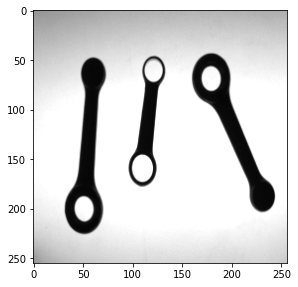

Image:  TESI01.BMP 
Shape:  (255, 256)


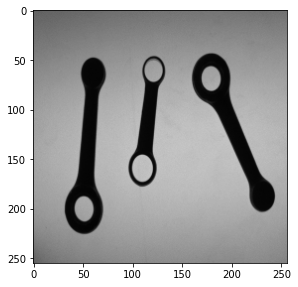

Image:  TESI12.BMP 
Shape:  (255, 256)


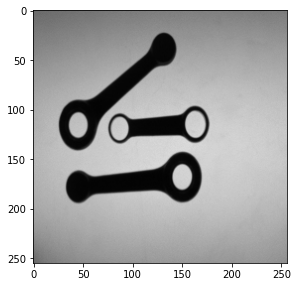

Image:  TESI21.BMP 
Shape:  (255, 256)


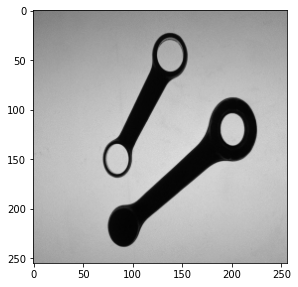

Image:  TESI31.BMP 
Shape:  (255, 256)


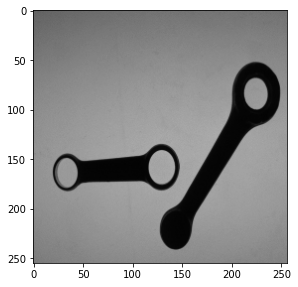

Image:  Tesi33.bmp 
Shape:  (255, 256)


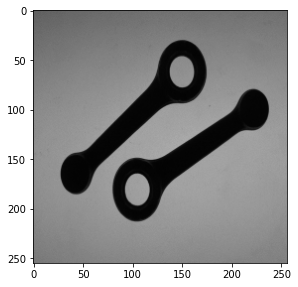

Image:  TESI44.BMP 
Shape:  (255, 256)


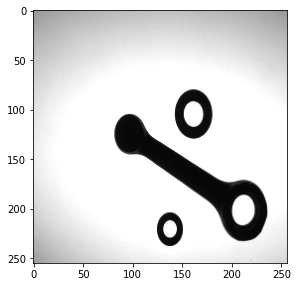

Image:  TESI47.BMP 
Shape:  (255, 256)


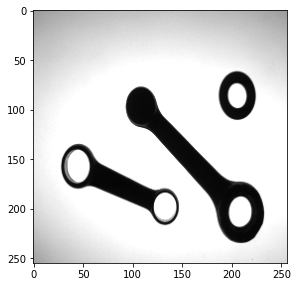

Image:  TESI48.BMP 
Shape:  (255, 256)


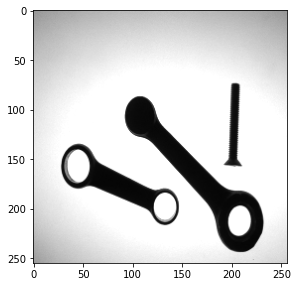

Image:  TESI49.BMP 
Shape:  (255, 256)


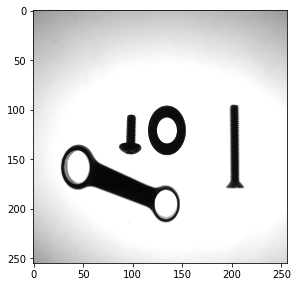

Image:  TESI90.BMP 
Shape:  (255, 256)


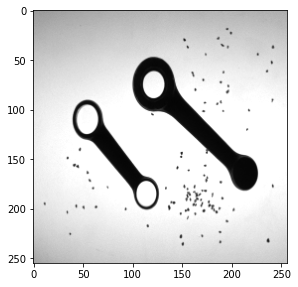

Image:  TESI92.BMP 
Shape:  (255, 256)


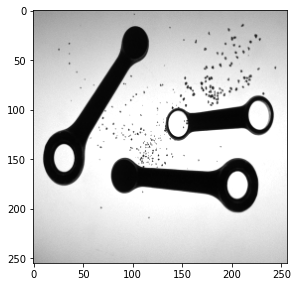

Image:  TESI98.BMP 
Shape:  (255, 256)


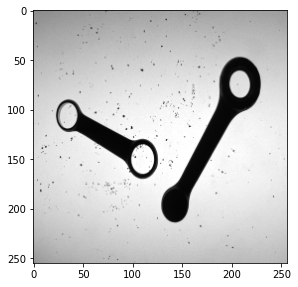

In [3]:
images = load_images("images/", input_images_name)
show_images(images, input_images_name)

### Show gray-level histograms
Computing the gray-level histograms of the images is not directly necessary for solving the task but can be intersting and useful to see the differences between are the images.

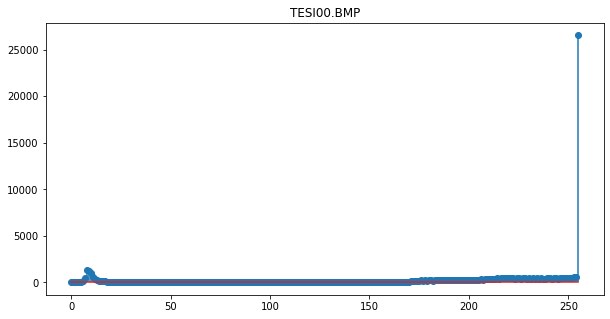

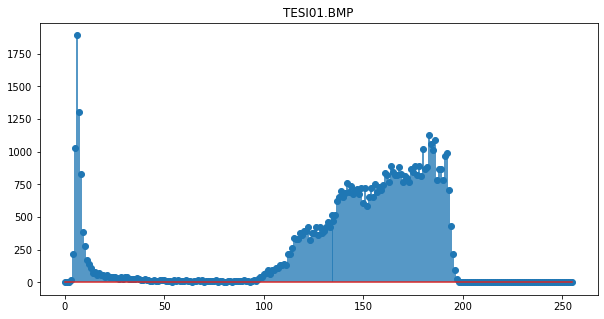

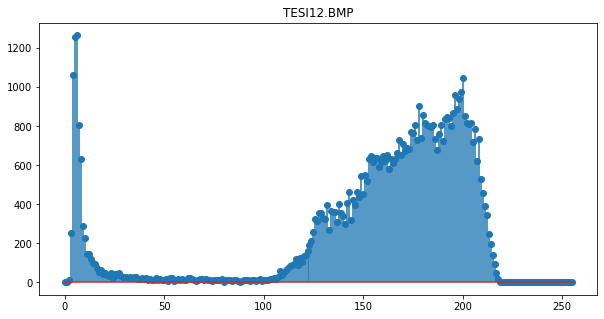

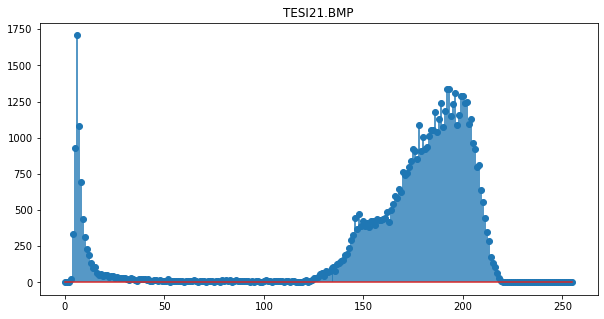

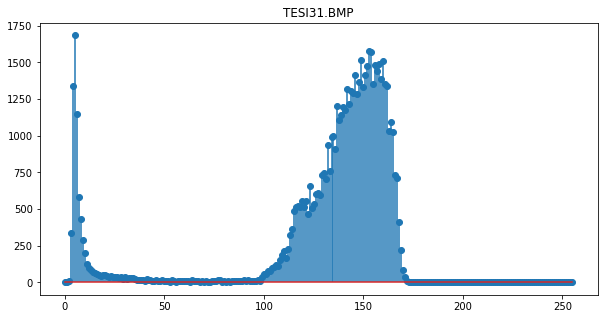

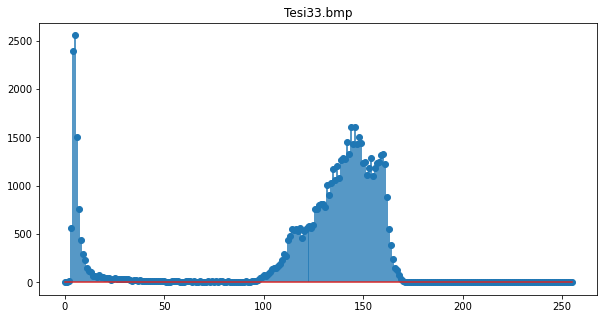

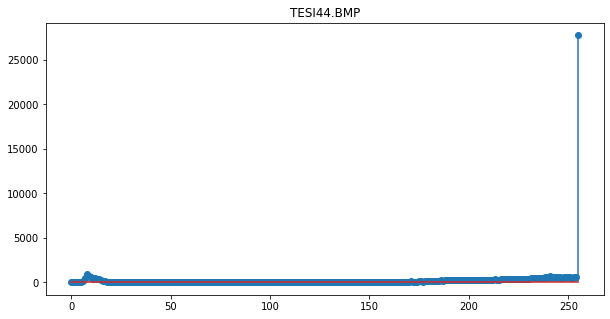

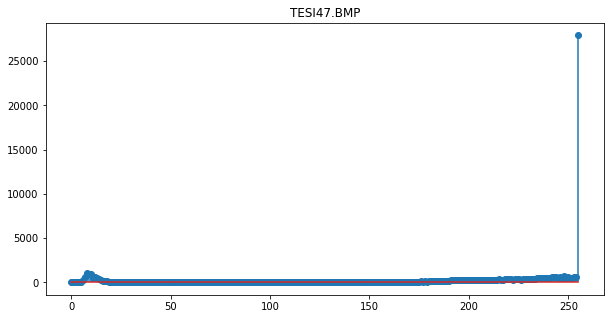

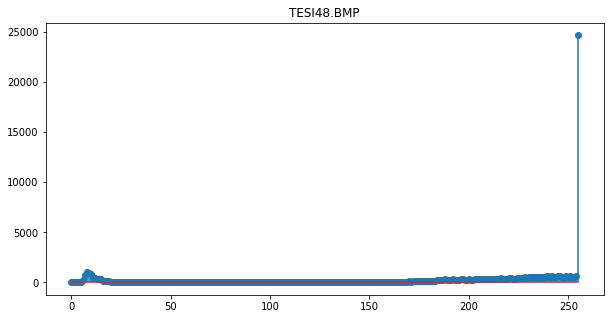

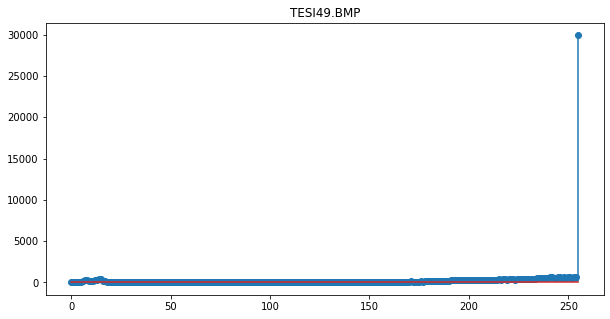

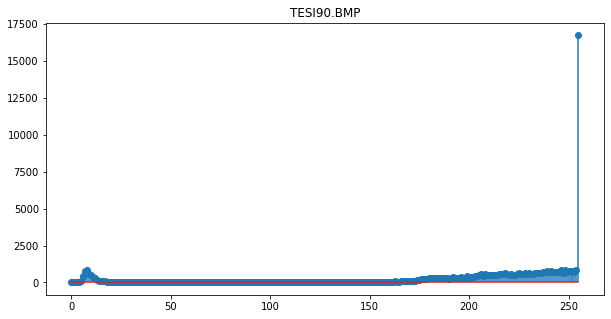

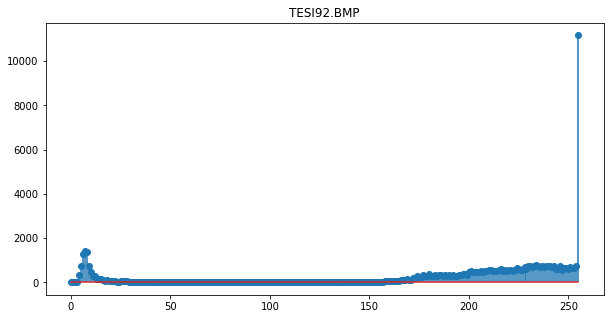

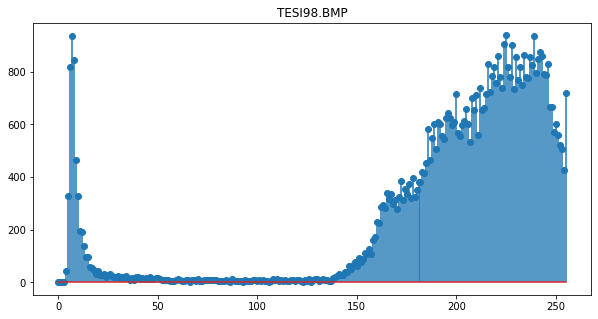

In [4]:
histograms = compute_histograms(images, input_images_name, verbose=True)

### Scattered iron powder noise (second task, point 3)
This step allows to facilitate the connecting rod inspection by denoising the images respect to the dirty area due to the presence of scattered iron powder. This is a form of impulse noise and it can be faced applying a few times (5 in my case) a 3x3 median filter. This procedure doesn't remove all this type of noise in 2/3 images; nevertheless, it reduces the noise enough for our purposes, given that after the image binarization step all the noise is absent (i.e. it is classified correctly as background).

Applying median filter of size  3 ...
Image:  TESI00.BMP 
Shape:  (255, 256)


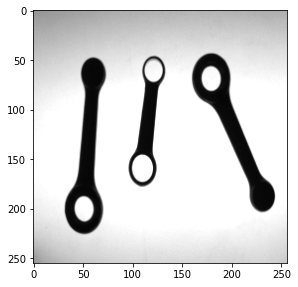

Image:  TESI01.BMP 
Shape:  (255, 256)


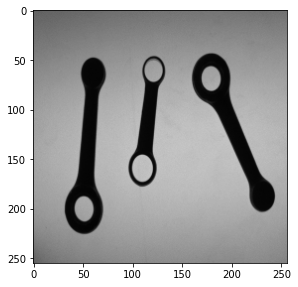

Image:  TESI12.BMP 
Shape:  (255, 256)


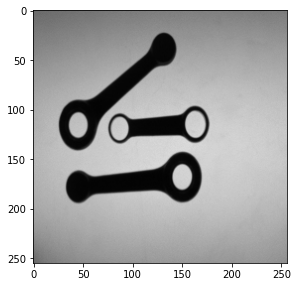

Image:  TESI21.BMP 
Shape:  (255, 256)


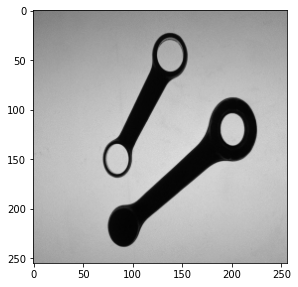

Image:  TESI31.BMP 
Shape:  (255, 256)


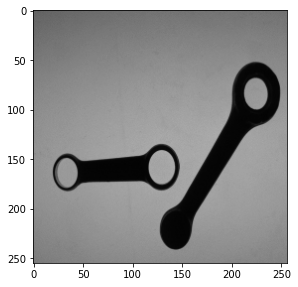

Image:  Tesi33.bmp 
Shape:  (255, 256)


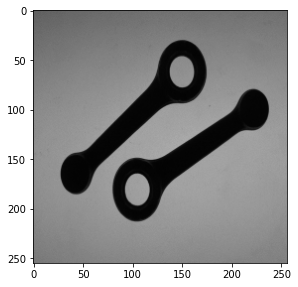

Image:  TESI44.BMP 
Shape:  (255, 256)


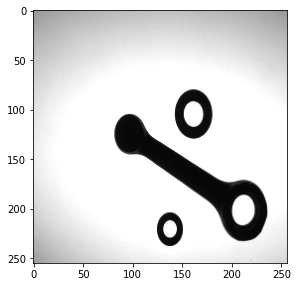

Image:  TESI47.BMP 
Shape:  (255, 256)


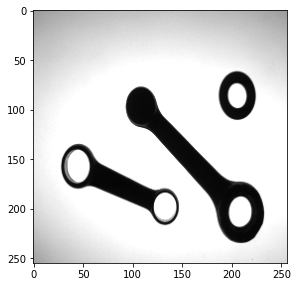

Image:  TESI48.BMP 
Shape:  (255, 256)


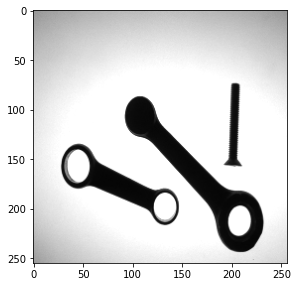

Image:  TESI49.BMP 
Shape:  (255, 256)


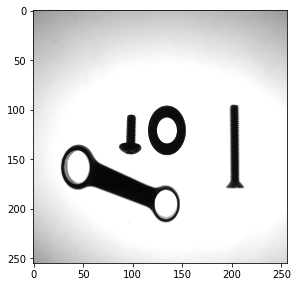

Image:  TESI90.BMP 
Shape:  (255, 256)


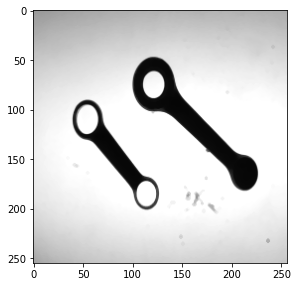

Image:  TESI92.BMP 
Shape:  (255, 256)


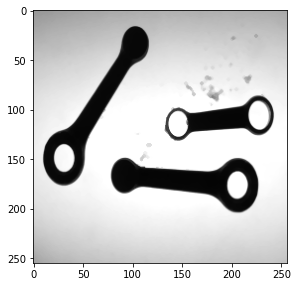

Image:  TESI98.BMP 
Shape:  (255, 256)


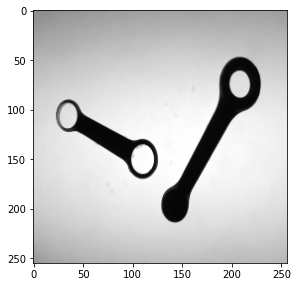

In [5]:
# Remove scattered iron powder noise
# THIS OVERWRITE THE IMAGES: running it N times means applying N*5 times the median filter.
NUM_TIMES_MEDIAN_FILTER_TO_BE_APPLIED = 5
images_names_with_impulse_noise = ['TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']
idx_images_with_impulse_noise = [input_images_name.index(image_name)
                                     for image_name in images_names_with_impulse_noise]
# Remove scattered iron powder noise
# THIS OVERWRITE THE IMAGES: running it N times means applying N*5 times the median filter.
for i in range(NUM_TIMES_MEDIAN_FILTER_TO_BE_APPLIED):
    images = apply_median_filter(images, MEDIAN_FILTER_KERNEL_SIZE, idx_images_with_impulse_noise)

print("Applying median filter of size ", MEDIAN_FILTER_KERNEL_SIZE, "...")
show_images(images, input_images_name)

### Image segmentation
This step produce binary images from the previous one applying thresholding where the treshold is defined automatically trough Otsu's algorithm.

Image:  TESI00.BMP 
Shape:  (255, 256)


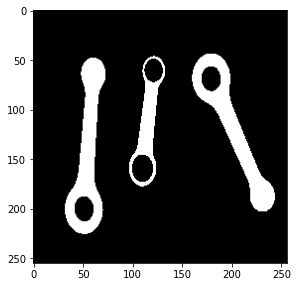

Image:  TESI01.BMP 
Shape:  (255, 256)


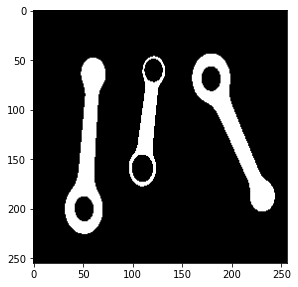

Image:  TESI12.BMP 
Shape:  (255, 256)


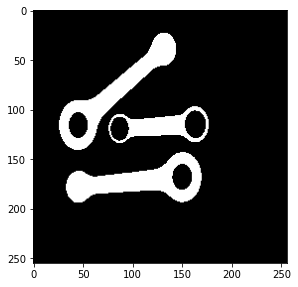

Image:  TESI21.BMP 
Shape:  (255, 256)


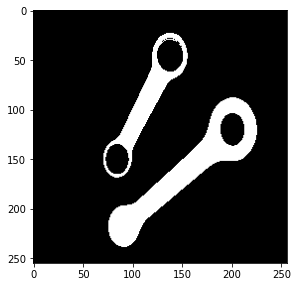

Image:  TESI31.BMP 
Shape:  (255, 256)


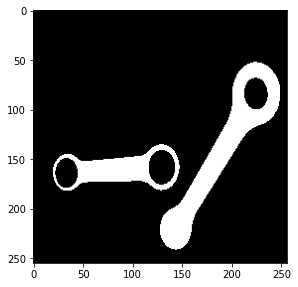

Image:  Tesi33.bmp 
Shape:  (255, 256)


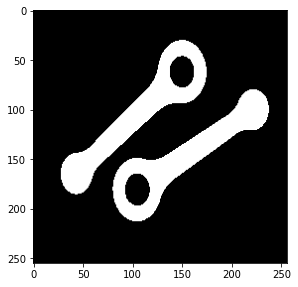

Image:  TESI44.BMP 
Shape:  (255, 256)


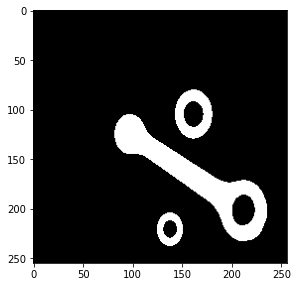

Image:  TESI47.BMP 
Shape:  (255, 256)


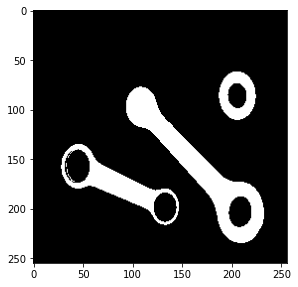

Image:  TESI48.BMP 
Shape:  (255, 256)


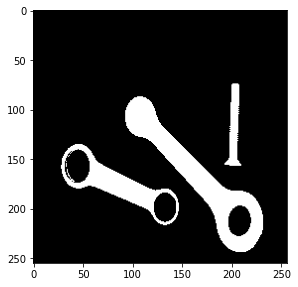

Image:  TESI49.BMP 
Shape:  (255, 256)


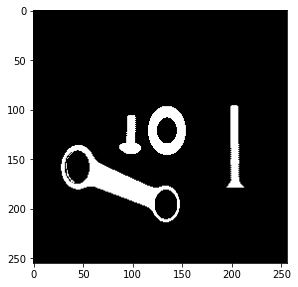

Image:  TESI90.BMP 
Shape:  (255, 256)


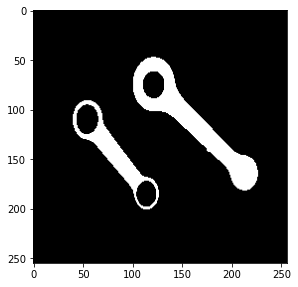

Image:  TESI92.BMP 
Shape:  (255, 256)


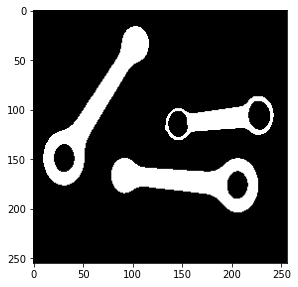

Image:  TESI98.BMP 
Shape:  (255, 256)


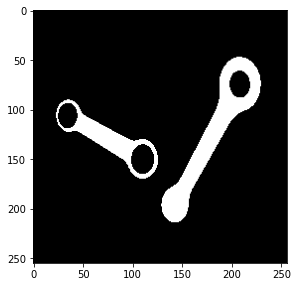

In [6]:
binary_images = binarize_images(images)
show_images(binary_images, input_images_name)

### Closing procedure
This procedure is implemented to solve a problem with the connecting rod of type B in the image *TESI21.BMP*. Indeed, in this image the inner part of one hole of this connecting rod is visible, and being it lighter than the connecting rod, this led to the presence of a really small hole in corrispondence on the lighter area, after the segmentation.  
In general this problem occurs when some of the gray level of the connecting rods are above the threshold used for binarization, producing a not ideal segmentation.  
This problem is solved using closing (dilation + erosion).

Closing images with a (3, 3) structuring element ...
Image:  TESI00.BMP 
Shape:  (255, 256)


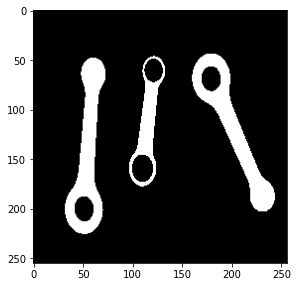

Image:  TESI01.BMP 
Shape:  (255, 256)


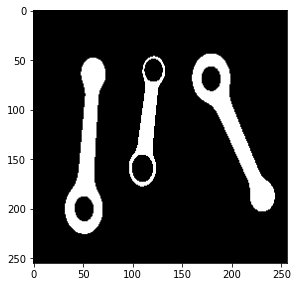

Image:  TESI12.BMP 
Shape:  (255, 256)


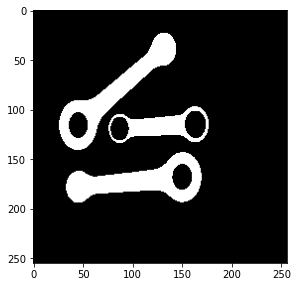

Image:  TESI21.BMP 
Shape:  (255, 256)


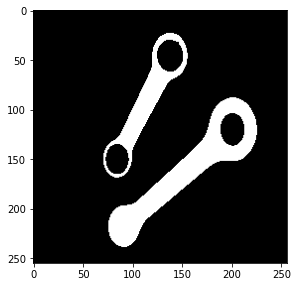

Image:  TESI31.BMP 
Shape:  (255, 256)


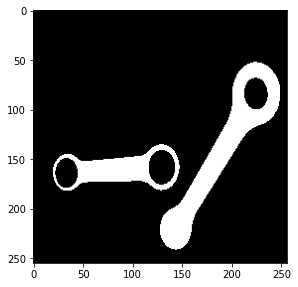

Image:  Tesi33.bmp 
Shape:  (255, 256)


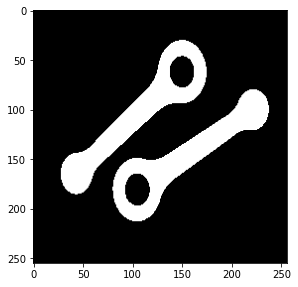

Image:  TESI44.BMP 
Shape:  (255, 256)


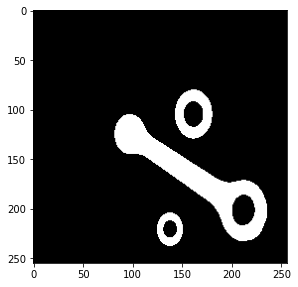

Image:  TESI47.BMP 
Shape:  (255, 256)


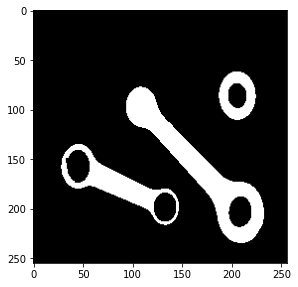

Image:  TESI48.BMP 
Shape:  (255, 256)


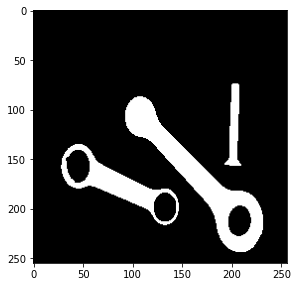

Image:  TESI49.BMP 
Shape:  (255, 256)


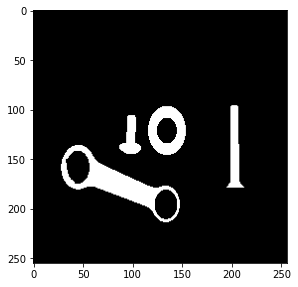

Image:  TESI90.BMP 
Shape:  (255, 256)


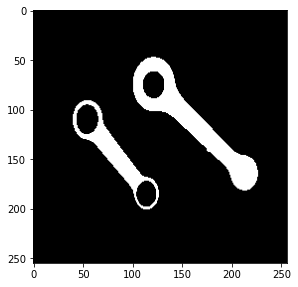

Image:  TESI92.BMP 
Shape:  (255, 256)


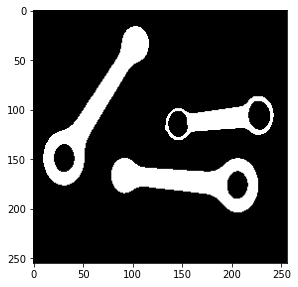

Image:  TESI98.BMP 
Shape:  (255, 256)


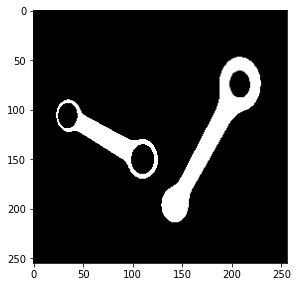

In [7]:
# Applying closing to solve countourn detection for the B type connecting rod in the image 'TESI21.BMP'.
# Without this preprocessing step the classification of the connecting rod type failes.
binary_images = close_images(binary_images, CLOSING_ELEMENT_KERNEL_DIM)
print("Closing images with a", CLOSING_ELEMENT_KERNEL_DIM, "structuring element ...")
show_images(binary_images, input_images_name)

### Connected components labeling
Once computed the binary images the following step is to find the connected components and labeling them. At this point, the connected components are either connecting rods or distractors. The algorithm used is Spaghetti algorithm with 8 connectivity.

Image:  TESI00.BMP 
Shape:  (255, 256)


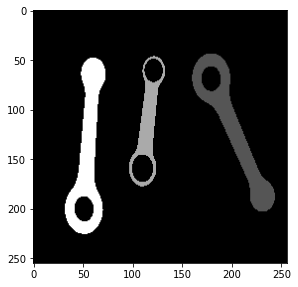

Image:  TESI01.BMP 
Shape:  (255, 256)


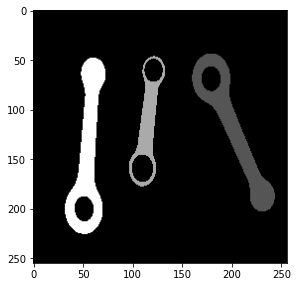

Image:  TESI12.BMP 
Shape:  (255, 256)


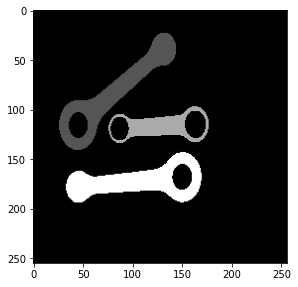

Image:  TESI21.BMP 
Shape:  (255, 256)


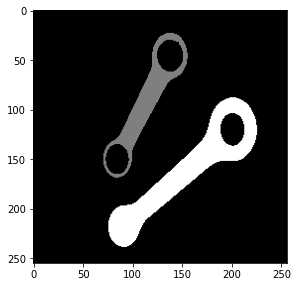

Image:  TESI31.BMP 
Shape:  (255, 256)


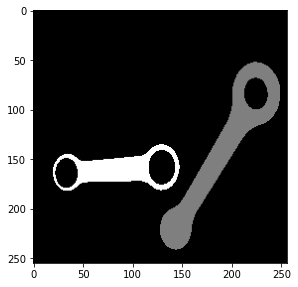

Image:  Tesi33.bmp 
Shape:  (255, 256)


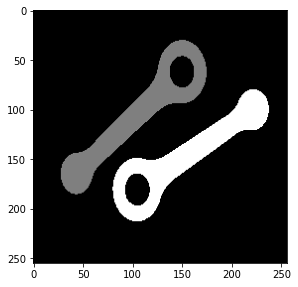

Image:  TESI44.BMP 
Shape:  (255, 256)


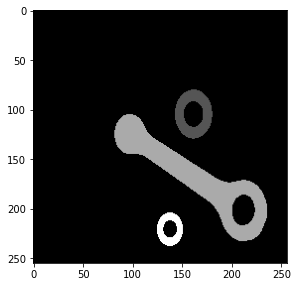

Image:  TESI47.BMP 
Shape:  (255, 256)


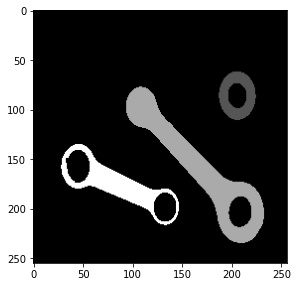

Image:  TESI48.BMP 
Shape:  (255, 256)


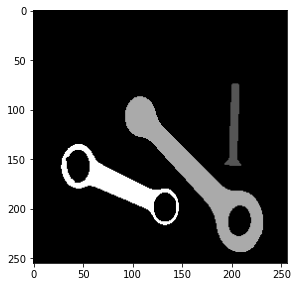

Image:  TESI49.BMP 
Shape:  (255, 256)


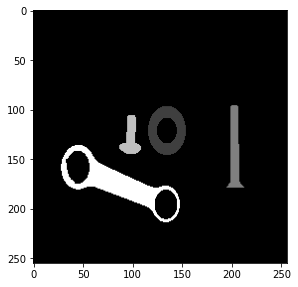

Image:  TESI90.BMP 
Shape:  (255, 256)


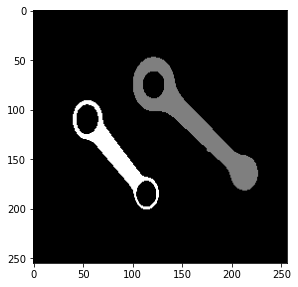

Image:  TESI92.BMP 
Shape:  (255, 256)


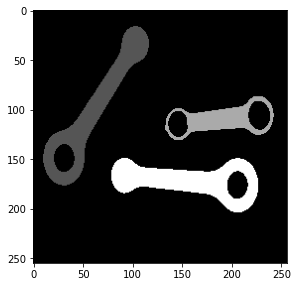

Image:  TESI98.BMP 
Shape:  (255, 256)


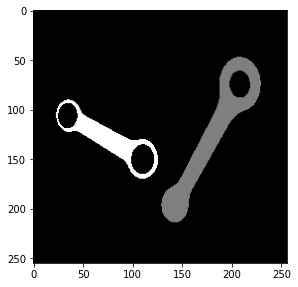

In [8]:
num_connected_components, labeled_images, stats, centroids = compute_connected_components(binary_images)
items_centroids = [image_stat[1:] for image_stat in centroids]
# the third parameter is put to True to perfomr linear contrast streching, in order to see the results 
# of the labeling
show_images(labeled_images, input_images_name, True)

### Contours extraction
A crucial step in the pipeline is the contours extraction. The contours of the connecting rods are essential for the next steps and they will be analyzed and processed to extact features. These features will be leveraged to accomplish the following requests.

In [9]:
labels = [sorted(list(set(np.unique(labeled_images[i]))-{0})) for i in range(len(labeled_images))]
connecting_rods_contours = compute_connecting_rods_contours(labeled_images, labels)

## 1. Connecting rods classification (A or B), including distractors elimination (second task, point 1)

Now it's time to classify the connected components: the aim is to identify the distractors (screws and washers) and to distinguish connecting rods of type A respect to the ones of type B. In order to do this 2 features were defined:
1. number of holes
2. Haralick's circularity

Analyzing the different objects I noticed that:
1. type A connecting rods have 1 hole, while type B ones have 2 holes
2. screws don't have holes
3. connecting rods have haralick circularity around 2 (1.84 ~ 2.14)
4. washers have haralick circularity around 10 (9.66 ~ 10.21)

So these are the rules I defined:
1. object without holes or more than 2 holes and objects with Haralick's circularity > 3 are classified as NOT_A_CONNECTING_ROD
2. all the others objects are either connecting rods of type A (wether they have 1 hole) or of type B (2 holes)

All the connected components that are not connecting rods are then removed from the images.

Types
Image:  TESI00.BMP
Connecting rod type:  A


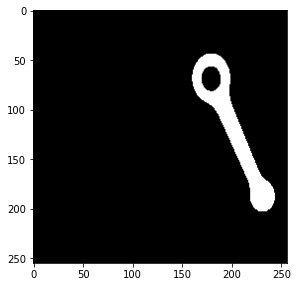

Connecting rod type:  B


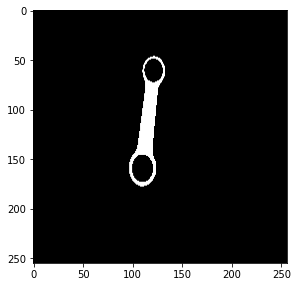

Connecting rod type:  A


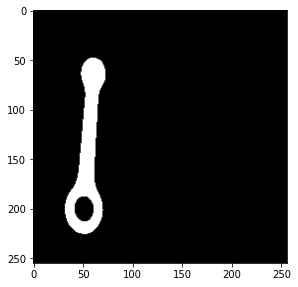

Image:  TESI01.BMP
Connecting rod type:  A


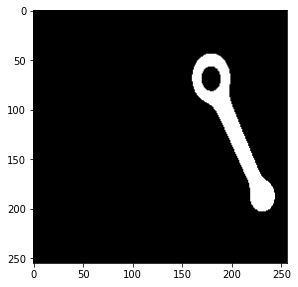

Connecting rod type:  B


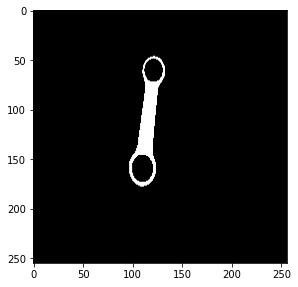

Connecting rod type:  A


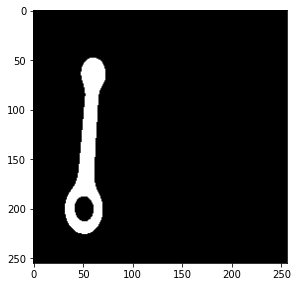

Image:  TESI12.BMP
Connecting rod type:  A


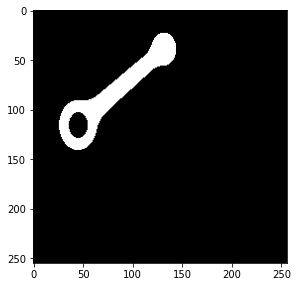

Connecting rod type:  B


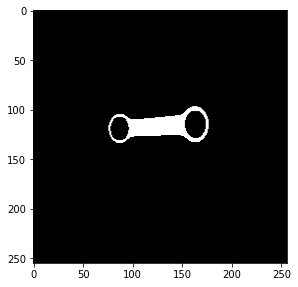

Connecting rod type:  A


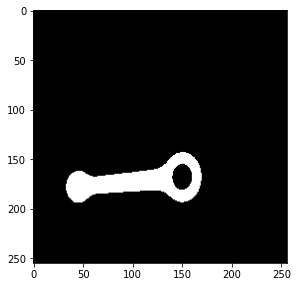

Image:  TESI21.BMP
Connecting rod type:  B


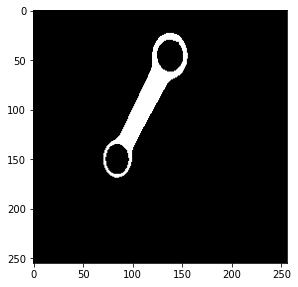

Connecting rod type:  A


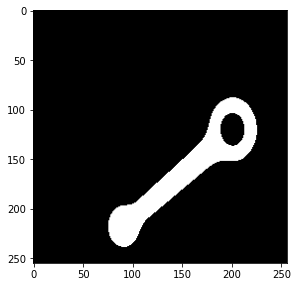

Image:  TESI31.BMP
Connecting rod type:  A


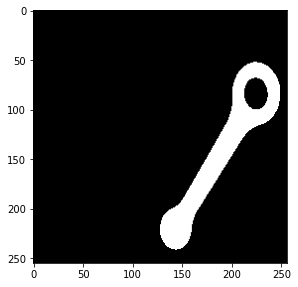

Connecting rod type:  B


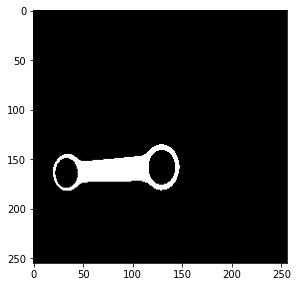

Image:  Tesi33.bmp
Connecting rod type:  A


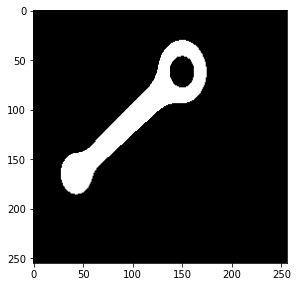

Connecting rod type:  A


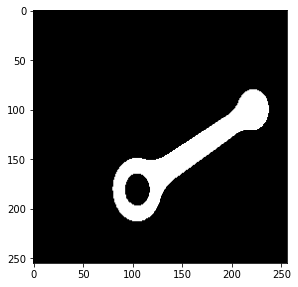

Image:  TESI44.BMP
Connecting rod type:  OTHER


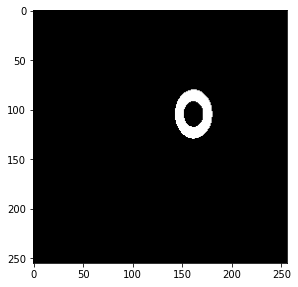

Connecting rod type:  A


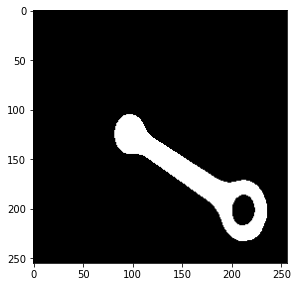

Connecting rod type:  OTHER


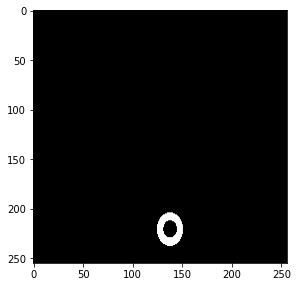

Image:  TESI47.BMP
Connecting rod type:  OTHER


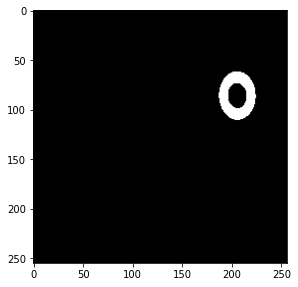

Connecting rod type:  A


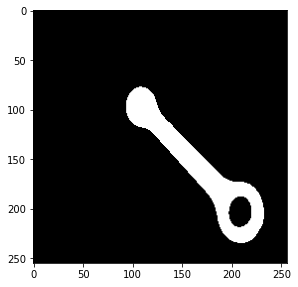

Connecting rod type:  B


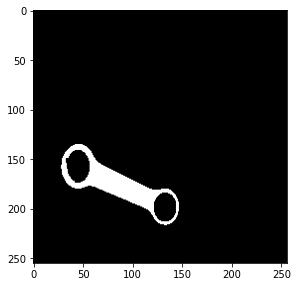

Image:  TESI48.BMP
Connecting rod type:  OTHER


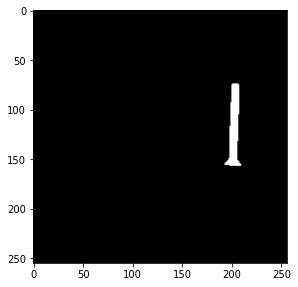

Connecting rod type:  A


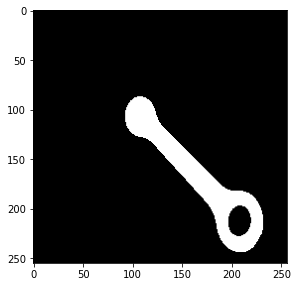

Connecting rod type:  B


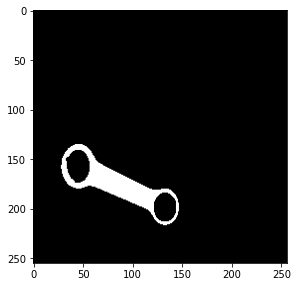

Image:  TESI49.BMP
Connecting rod type:  OTHER


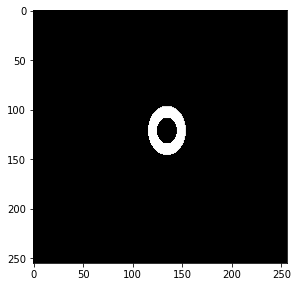

Connecting rod type:  OTHER


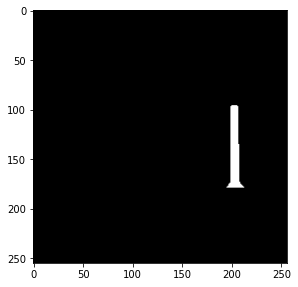

Connecting rod type:  OTHER


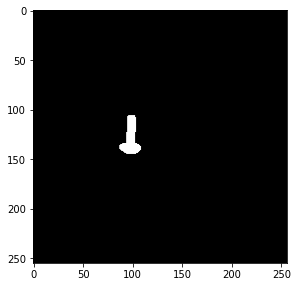

Connecting rod type:  B


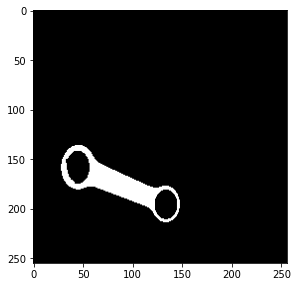

Image:  TESI90.BMP
Connecting rod type:  A


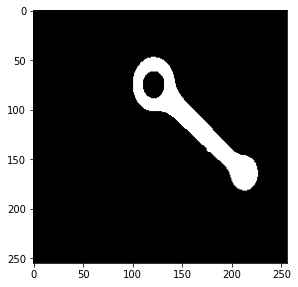

Connecting rod type:  B


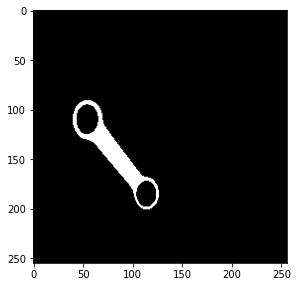

Image:  TESI92.BMP
Connecting rod type:  A


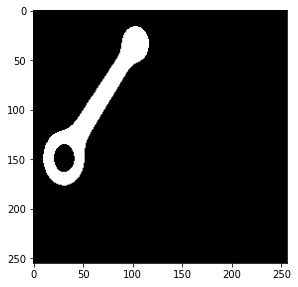

Connecting rod type:  B


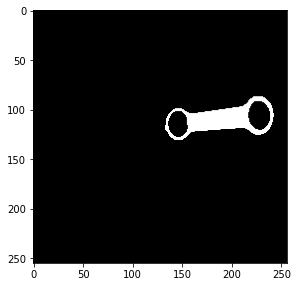

Connecting rod type:  A


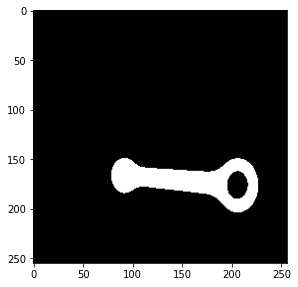

Image:  TESI98.BMP
Connecting rod type:  A


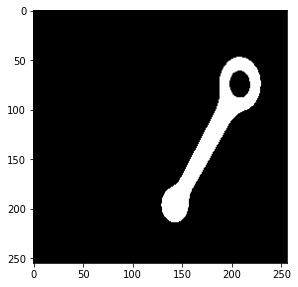

Connecting rod type:  B


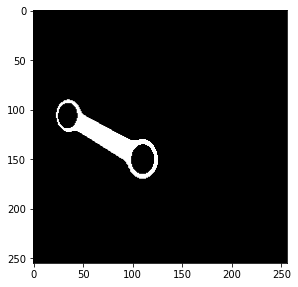

In [10]:
connecting_rods_type = classify_connecting_rods(connecting_rods_contours, items_centroids)
show_connected_components(labeled_images, labels, input_images_name, connecting_rods_type, "Types", 
                          "Connecting rod type: ")

### Distractors elimination

Image:  TESI00.BMP 
Shape:  (255, 256)


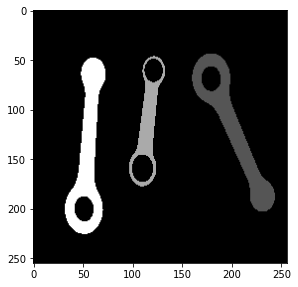

Image:  TESI01.BMP 
Shape:  (255, 256)


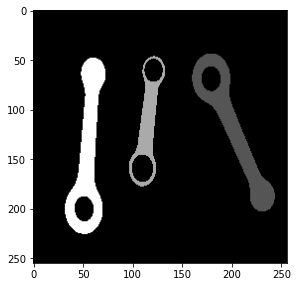

Image:  TESI12.BMP 
Shape:  (255, 256)


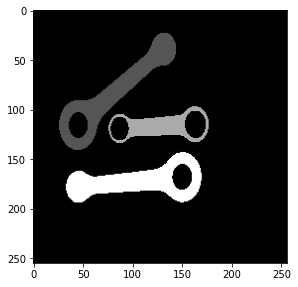

Image:  TESI21.BMP 
Shape:  (255, 256)


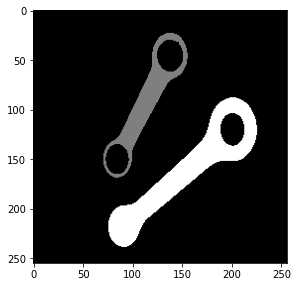

Image:  TESI31.BMP 
Shape:  (255, 256)


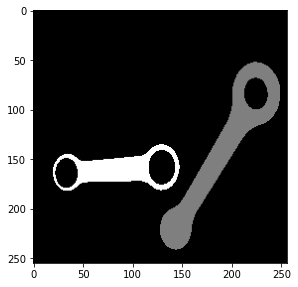

Image:  Tesi33.bmp 
Shape:  (255, 256)


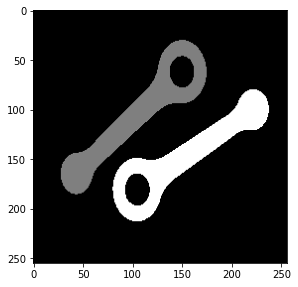

Image:  TESI44.BMP 
Shape:  (255, 256)


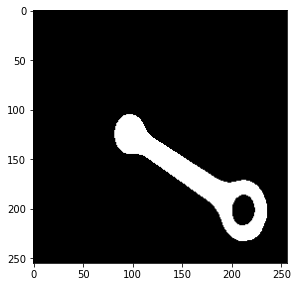

Image:  TESI47.BMP 
Shape:  (255, 256)


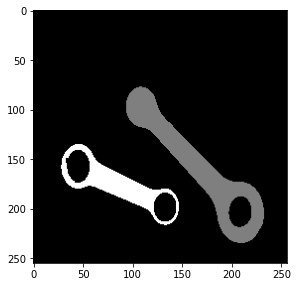

Image:  TESI48.BMP 
Shape:  (255, 256)


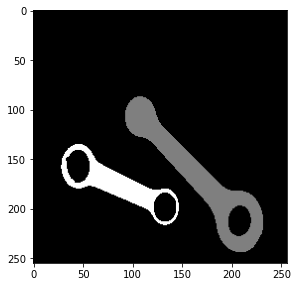

Image:  TESI49.BMP 
Shape:  (255, 256)


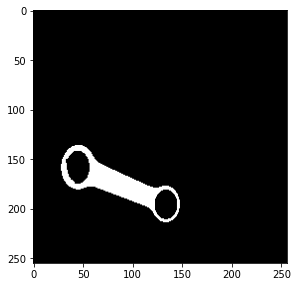

Image:  TESI90.BMP 
Shape:  (255, 256)


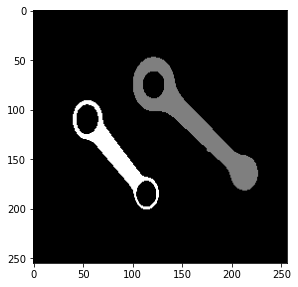

Image:  TESI92.BMP 
Shape:  (255, 256)


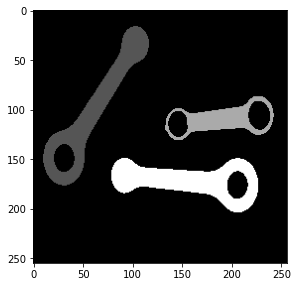

Image:  TESI98.BMP 
Shape:  (255, 256)


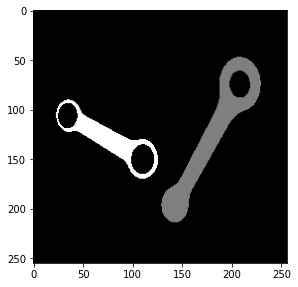

In [11]:
# Remove the distractors from the images (labeled_images and binary_images)
cleaned_binary_images = np.copy(binary_images)
# cleaned_labeled_images = np.copy(labeled_images)
labels_removed = []
for i in range(len(connecting_rods_type)):
    for j in range(len(connecting_rods_type[i])):
        if connecting_rods_type[i][j] == NOT_A_CONNECTING_ROD_LABEL:
            # Remove distractors 
            cleaned_binary_images[i] = np.where(labeled_images[i] != labels[i][j], cleaned_binary_images[i], 0)
            # cleaned_labeled_images[i] = np.where(labeled_images[i] != labels[i][j], labeled_images[i], 0)

num_connected_components, labeled_images, stats, centroids = compute_connected_components(cleaned_binary_images)
items_centroids = [image_stat[1:] for image_stat in centroids]
items_stats = [image_stat[1:] for image_stat in stats]
labels = [sorted(list(set(np.unique(labeled_images[i]))-{0})) for i in range(len(labeled_images))]
connecting_rods_contours = compute_connecting_rods_contours(labeled_images, labels)
# show_images(binary_images, input_images_name, True)
show_images(labeled_images, input_images_name, True)

## 2. Position and orientation
The second request of the first task consists in extracting position and orientation. The position is described by some information returned from the procedure that finds the connected components, which are:
1. centroid coordinates
2. the coordinates of the top left corner of the rectangle (not oriented) that contains the connecting rods, with its width and height

Instead, the orientation is extracted using the function of openCV *fitEllipse*, whose the third return value is indeed the orientation respect to the vertical axis (i.e. a vertical connecting rod has orientation equal to 0).

### Connecting rods position

Positions
Image:  TESI00.BMP
Connecting rod position:  {'centroid': (201, 119), 'leftmost_x': 160, 'topmost_y': 44, 'width': 84, 'height': 159}


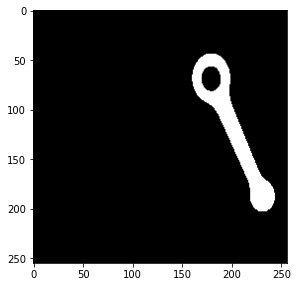

Connecting rod position:  {'centroid': (115, 114), 'leftmost_x': 97, 'topmost_y': 46, 'width': 36, 'height': 132}


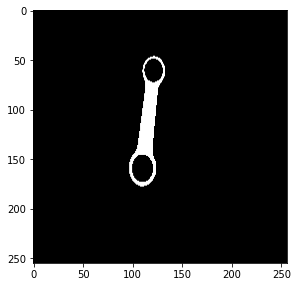

Connecting rod position:  {'centroid': (54, 141), 'leftmost_x': 32, 'topmost_y': 48, 'width': 41, 'height': 178}


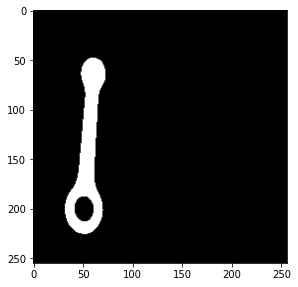

Image:  TESI01.BMP
Connecting rod position:  {'centroid': (201, 119), 'leftmost_x': 160, 'topmost_y': 44, 'width': 84, 'height': 159}


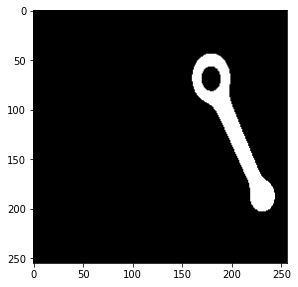

Connecting rod position:  {'centroid': (115, 113), 'leftmost_x': 97, 'topmost_y': 46, 'width': 36, 'height': 132}


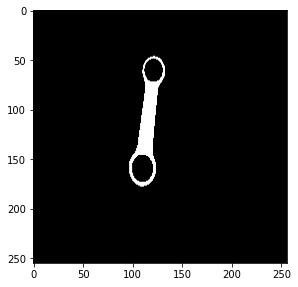

Connecting rod position:  {'centroid': (54, 141), 'leftmost_x': 32, 'topmost_y': 48, 'width': 41, 'height': 178}


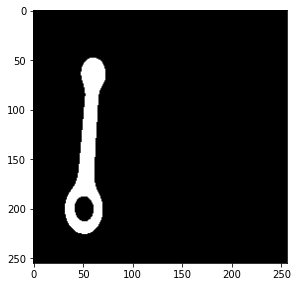

Image:  TESI12.BMP
Connecting rod position:  {'centroid': (82, 82), 'leftmost_x': 26, 'topmost_y': 23, 'width': 118, 'height': 118}


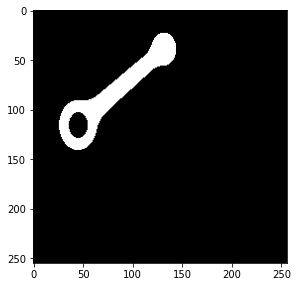

Connecting rod position:  {'centroid': (128, 116), 'leftmost_x': 76, 'topmost_y': 97, 'width': 101, 'height': 37}


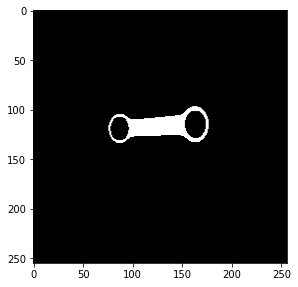

Connecting rod position:  {'centroid': (104, 172), 'leftmost_x': 33, 'topmost_y': 143, 'width': 137, 'height': 51}


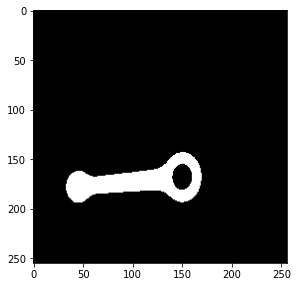

Image:  TESI21.BMP
Connecting rod position:  {'centroid': (114, 90), 'leftmost_x': 71, 'topmost_y': 23, 'width': 85, 'height': 146}


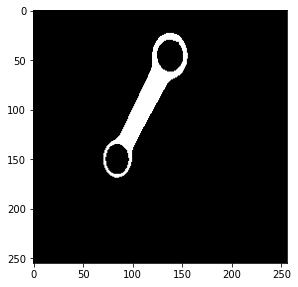

Connecting rod position:  {'centroid': (153, 162), 'leftmost_x': 76, 'topmost_y': 88, 'width': 150, 'height': 151}


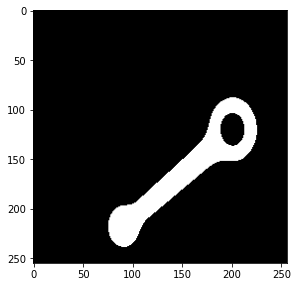

Image:  TESI31.BMP
Connecting rod position:  {'centroid': (189, 142), 'leftmost_x': 128, 'topmost_y': 52, 'width': 121, 'height': 190}


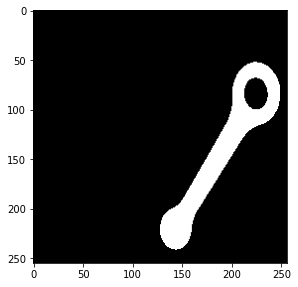

Connecting rod position:  {'centroid': (86, 160), 'leftmost_x': 20, 'topmost_y': 135, 'width': 128, 'height': 47}


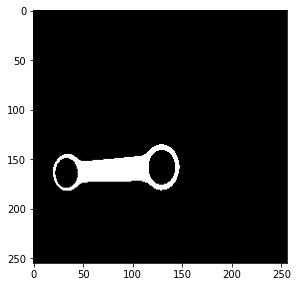

Image:  Tesi33.bmp
Connecting rod position:  {'centroid': (103, 105), 'leftmost_x': 28, 'topmost_y': 30, 'width': 147, 'height': 156}


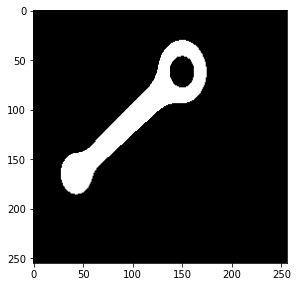

Connecting rod position:  {'centroid': (154, 145), 'leftmost_x': 80, 'topmost_y': 80, 'width': 158, 'height': 133}


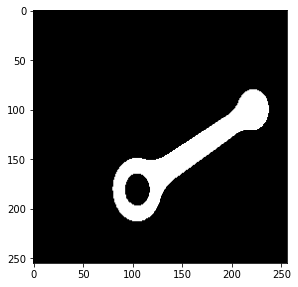

Image:  TESI44.BMP
Connecting rod position:  {'centroid': (162, 168), 'leftmost_x': 82, 'topmost_y': 105, 'width': 154, 'height': 128}


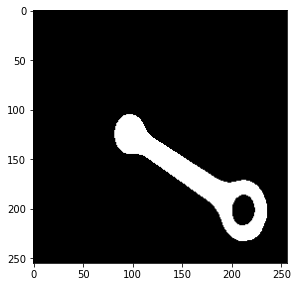

Image:  TESI47.BMP
Connecting rod position:  {'centroid': (165, 157), 'leftmost_x': 94, 'topmost_y': 77, 'width': 139, 'height': 158}


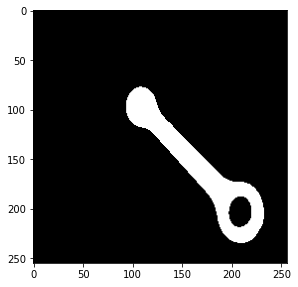

Connecting rod position:  {'centroid': (83, 174), 'leftmost_x': 28, 'topmost_y': 135, 'width': 119, 'height': 82}


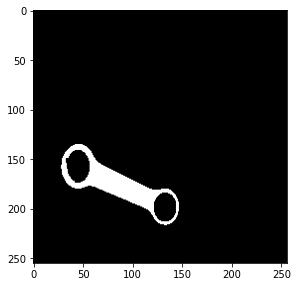

Image:  TESI48.BMP
Connecting rod position:  {'centroid': (164, 167), 'leftmost_x': 93, 'topmost_y': 87, 'width': 139, 'height': 157}


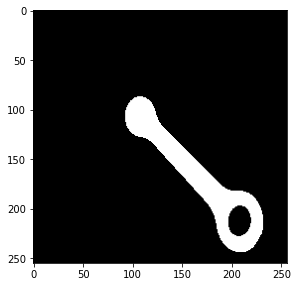

Connecting rod position:  {'centroid': (83, 174), 'leftmost_x': 28, 'topmost_y': 135, 'width': 119, 'height': 82}


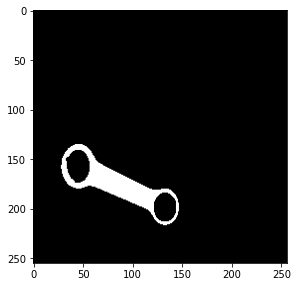

Image:  TESI49.BMP
Connecting rod position:  {'centroid': (83, 173), 'leftmost_x': 28, 'topmost_y': 136, 'width': 120, 'height': 78}


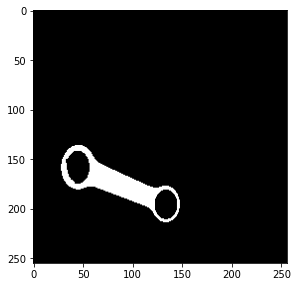

Image:  TESI90.BMP
Connecting rod position:  {'centroid': (160, 112), 'leftmost_x': 101, 'topmost_y': 47, 'width': 126, 'height': 135}


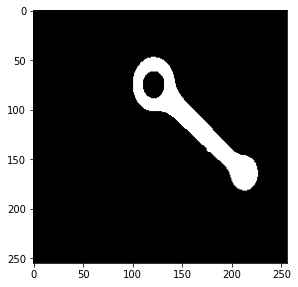

Connecting rod position:  {'centroid': (81, 143), 'leftmost_x': 40, 'topmost_y': 91, 'width': 87, 'height': 110}


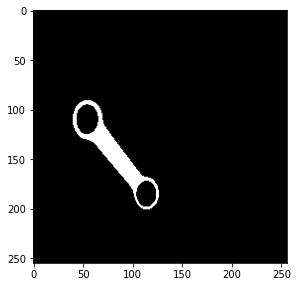

Image:  TESI92.BMP
Connecting rod position:  {'centroid': (61, 98), 'leftmost_x': 10, 'topmost_y': 16, 'width': 107, 'height': 161}


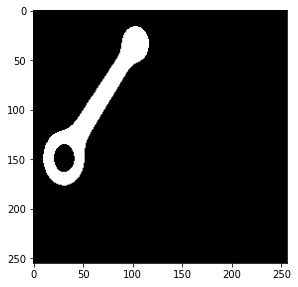

Connecting rod position:  {'centroid': (190, 109), 'leftmost_x': 133, 'topmost_y': 87, 'width': 110, 'height': 44}


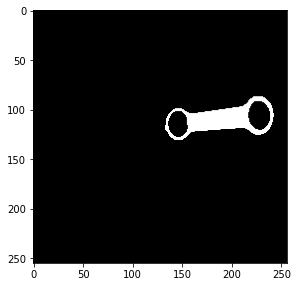

Connecting rod position:  {'centroid': (156, 171), 'leftmost_x': 79, 'topmost_y': 149, 'width': 148, 'height': 55}


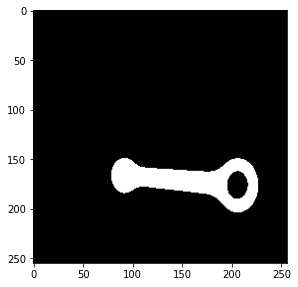

Image:  TESI98.BMP
Connecting rod position:  {'centroid': (179, 126), 'leftmost_x': 129, 'topmost_y': 47, 'width': 101, 'height': 167}


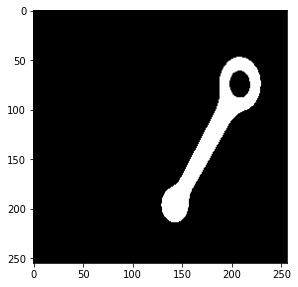

Connecting rod position:  {'centroid': (76, 129), 'leftmost_x': 23, 'topmost_y': 90, 'width': 103, 'height': 80}


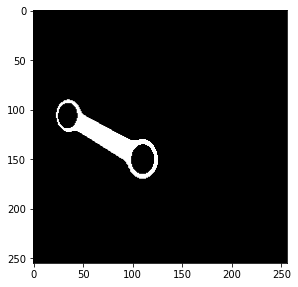

In [12]:
connecting_rods_position = get_connecting_rods_position(labels, items_centroids, items_stats)
show_connected_components(labeled_images, labels, input_images_name, connecting_rods_position, "Positions", 
                          "Connecting rod position: ")

### Connecting rods orientation

Orientations
Image:  TESI00.BMP
Connecting rod orientation:  113.29072570800781


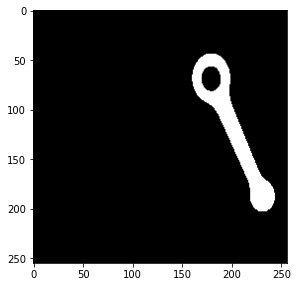

Connecting rod orientation:  83.45588731765747


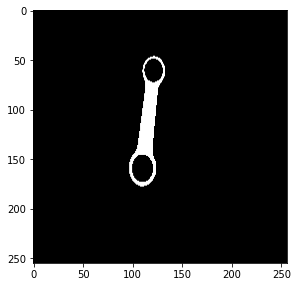

Connecting rod orientation:  86.00874876976013


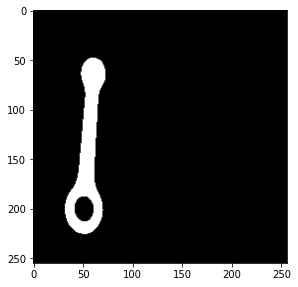

Image:  TESI01.BMP
Connecting rod orientation:  113.27793884277344


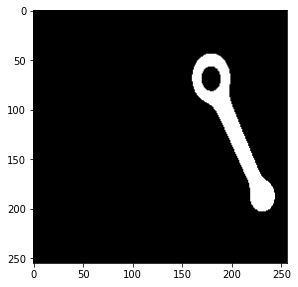

Connecting rod orientation:  83.43794918060303


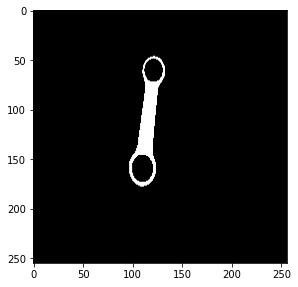

Connecting rod orientation:  86.00076079368591


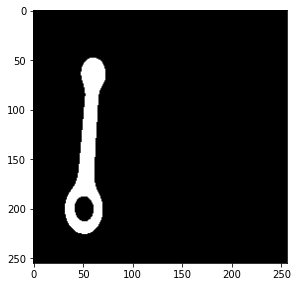

Image:  TESI12.BMP
Connecting rod orientation:  42.38233947753906


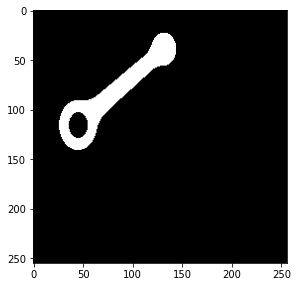

Connecting rod orientation:  3.3224334716796875


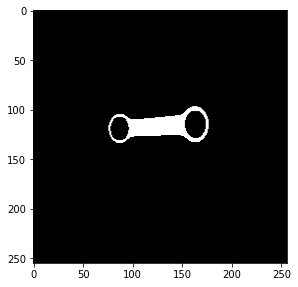

Connecting rod orientation:  5.553474426269531


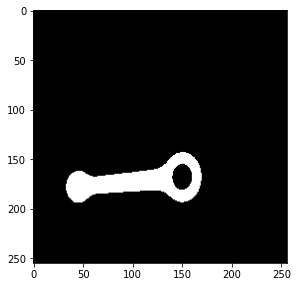

Image:  TESI21.BMP
Connecting rod orientation:  63.299123764038086


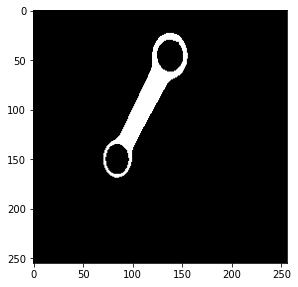

Connecting rod orientation:  42.49635314941406


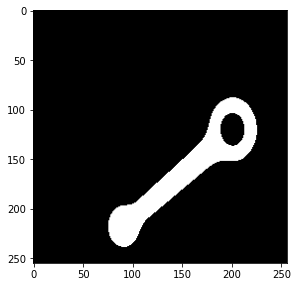

Image:  TESI31.BMP
Connecting rod orientation:  59.65122985839844


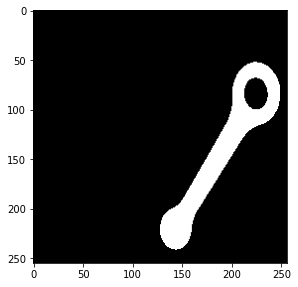

Connecting rod orientation:  3.249908447265625


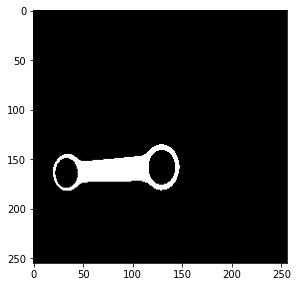

Image:  Tesi33.bmp
Connecting rod orientation:  44.73333740234375


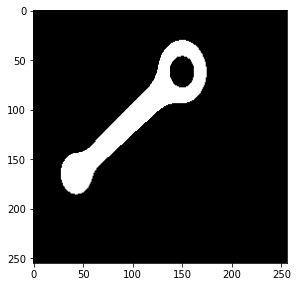

Connecting rod orientation:  35.47205352783203


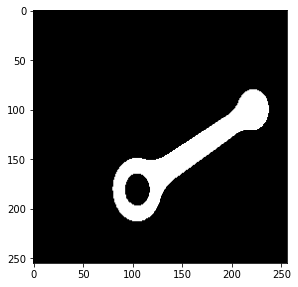

Image:  TESI44.BMP
Connecting rod orientation:  145.17333221435547


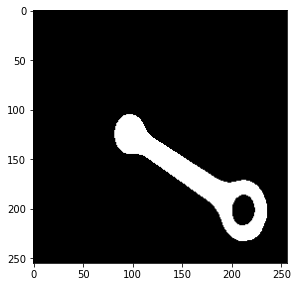

Image:  TESI47.BMP
Connecting rod orientation:  132.48910522460938


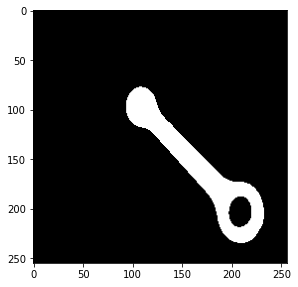

Connecting rod orientation:  154.2591552734375


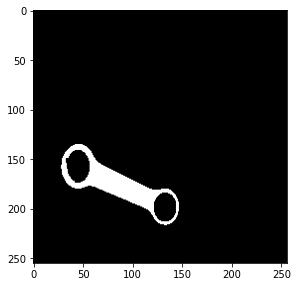

Image:  TESI48.BMP
Connecting rod orientation:  132.6331329345703


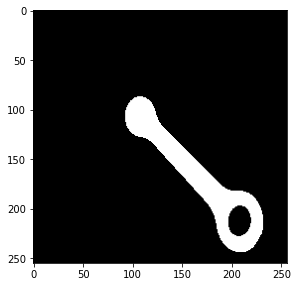

Connecting rod orientation:  154.21563720703125


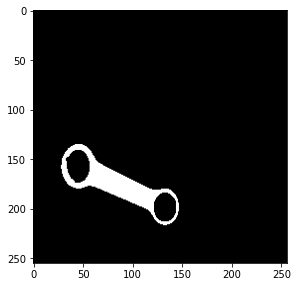

Image:  TESI49.BMP
Connecting rod orientation:  156.56529235839844


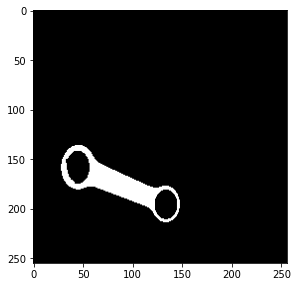

Image:  TESI90.BMP
Connecting rod orientation:  134.89370727539062


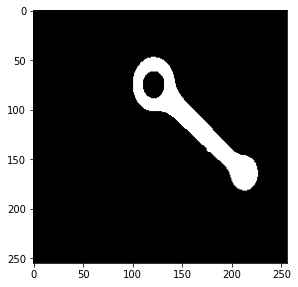

Connecting rod orientation:  128.21218872070312


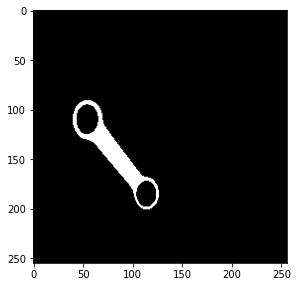

Image:  TESI92.BMP
Connecting rod orientation:  58.33938217163086


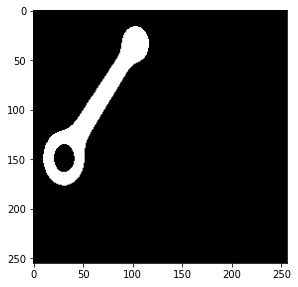

Connecting rod orientation:  6.480873107910156


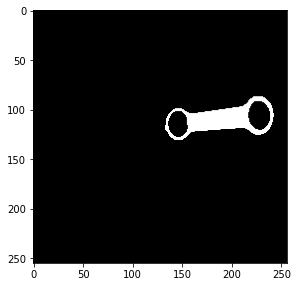

Connecting rod orientation:  174.74432373046875


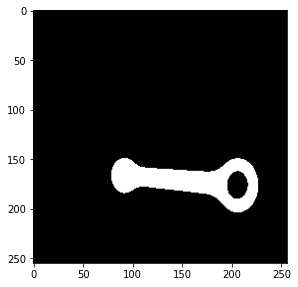

Image:  TESI98.BMP
Connecting rod orientation:  62.01925849914551


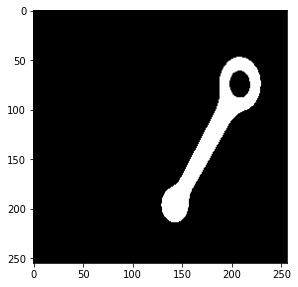

Connecting rod orientation:  149.05089569091797


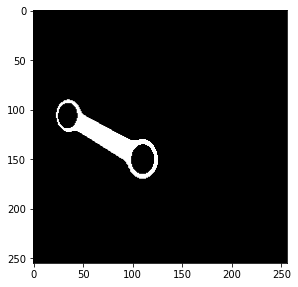

In [13]:
connecting_rods_orientation = compute_connecting_rods_orientation(connecting_rods_contours)
# the orientations in 'connecting_rods_orientation' are referred respect to the vertical axis: now I convert the 
# orientation such as it is referred respect to the horizontal axis, instead of the vertical axis: basically it 
# is needed to flip and rotate the reference point of the angle. Now a horizontal element has orientation = 0, 
# and it increases to π if the element rotates to the left
orientation_wrt_horizontal_axis = [[(angle * (-1) + 90) % 180 
                                   for angle in image] for image in connecting_rods_orientation]
show_connected_components(labeled_images, labels, input_images_name, orientation_wrt_horizontal_axis, "Orientations", 
                          "Connecting rod orientation: ")

## 3. Connecting rodes dimension
The length and the width are easily computed by finding the minimum oriented enclosing rectangle that contains the connecting rod: the two dimensions of this rectangle are length and width of the connecting rod (respectively the longer and the shorter). This is done using the openCV method *minAreaRect*.

The width at the barycenter of a connecting rod is computed in this way:
1. starting from the barycenter, shift towards the contour (in both ways) along the direction orthogonal to the orientation of the connnecting rod
2. the search described in *step 1* stops when a point outside the connecting rod is reached
3. the width at the barycenter is the distance between the last 2 points (one for each side) that were found during the search that are inside the connecting rod

In other words the solution consists in searching the 2 extreme points of the segment whose length is the width at the barycentre.

*About the width at the barycenter, executing the code below some images are plotted to provide a visual explanation (the white line connects these 2 extreme points and split the connecting rods in the correspondance of the barycenter)*

### Connecting rodes lenght and width

Dimensions (width and length)
Image:  TESI00.BMP
Connecting rod dimension:  (169.35345458984375, 39.776336669921875)


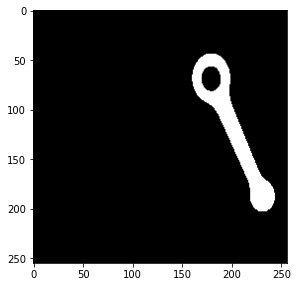

Connecting rod dimension:  (131.72950744628906, 26.979652404785156)


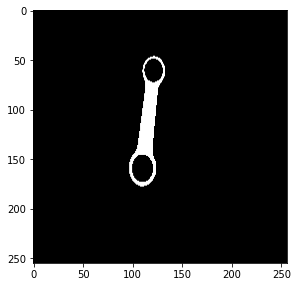

Connecting rod dimension:  (177.19308471679688, 38.087162017822266)


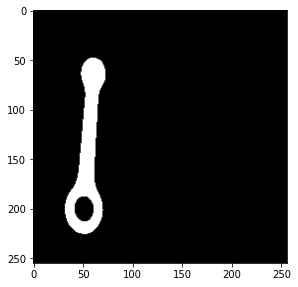

Image:  TESI01.BMP
Connecting rod dimension:  (169.0048828125, 39.8847770690918)


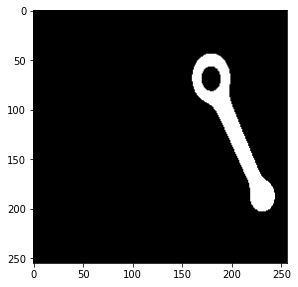

Connecting rod dimension:  (131.7313690185547, 26.98847007751465)


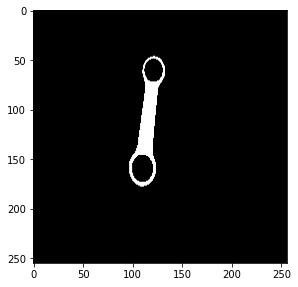

Connecting rod dimension:  (177.26246643066406, 37.2738037109375)


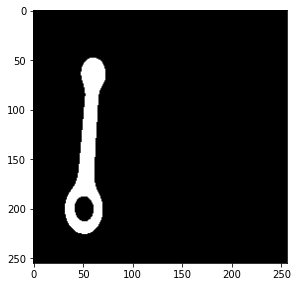

Image:  TESI12.BMP
Connecting rod dimension:  (152.0723114013672, 43.81410217285156)


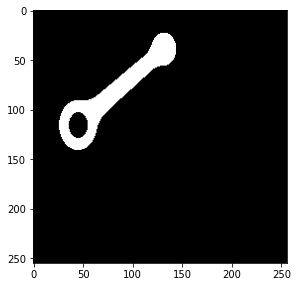

Connecting rod dimension:  (100.13441467285156, 35.087947845458984)


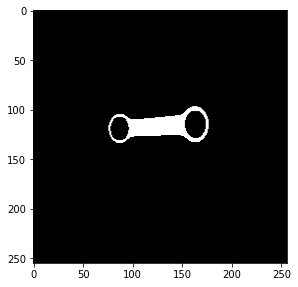

Connecting rod dimension:  (135.99996948242188, 49.99999237060547)


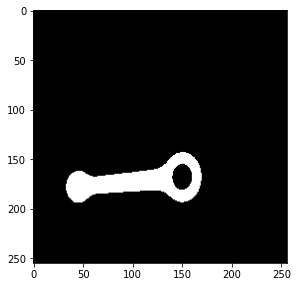

Image:  TESI21.BMP
Connecting rod dimension:  (156.5247344970703, 37.11872863769531)


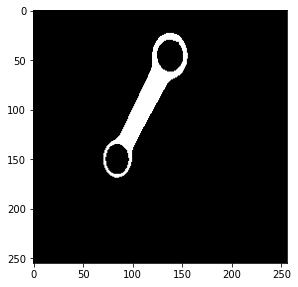

Connecting rod dimension:  (193.11891174316406, 55.79829025268555)


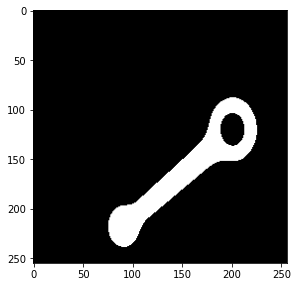

Image:  TESI31.BMP
Connecting rod dimension:  (208.0749969482422, 52.10930633544922)


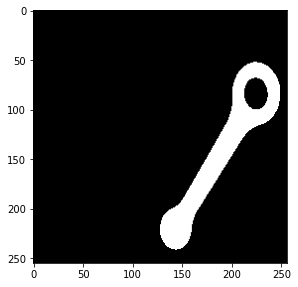

Connecting rod dimension:  (127.0, 46.0)


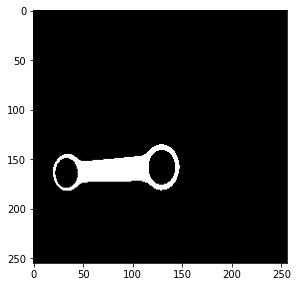

Image:  Tesi33.bmp
Connecting rod dimension:  (194.87330627441406, 55.562774658203125)


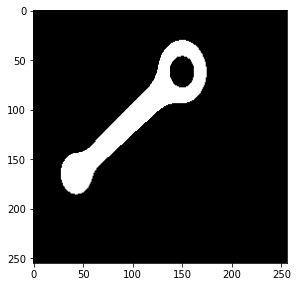

Connecting rod dimension:  (187.24734497070312, 58.51694869995117)


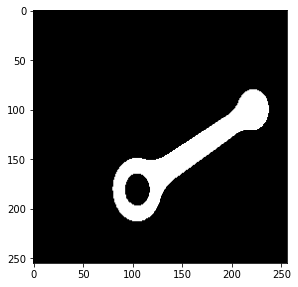

Image:  TESI44.BMP
Connecting rod dimension:  (182.08370971679688, 56.535911560058594)


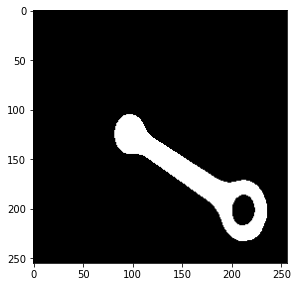

Image:  TESI47.BMP
Connecting rod dimension:  (192.34341430664062, 53.45278549194336)


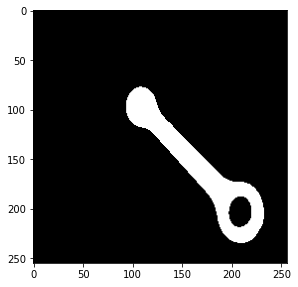

Connecting rod dimension:  (129.376220703125, 42.84679412841797)


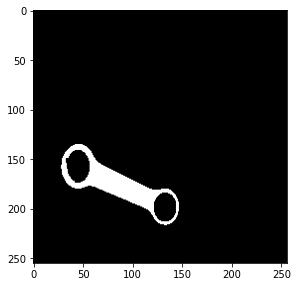

Image:  TESI48.BMP
Connecting rod dimension:  (192.4395751953125, 53.508365631103516)


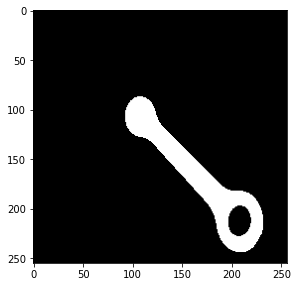

Connecting rod dimension:  (129.24472045898438, 42.48529052734375)


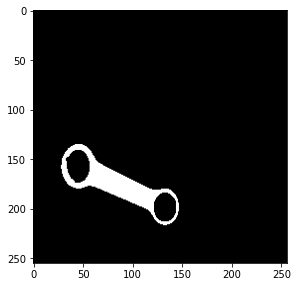

Image:  TESI49.BMP
Connecting rod dimension:  (128.4299774169922, 42.73374557495117)


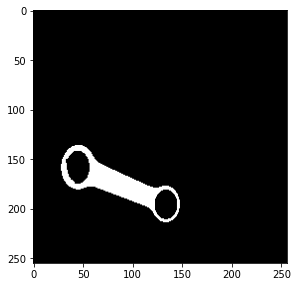

Image:  TESI90.BMP
Connecting rod dimension:  (168.071533203125, 47.85234069824219)


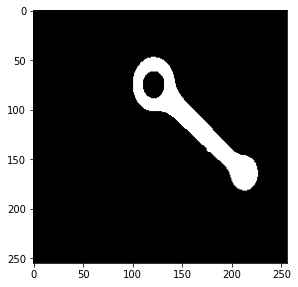

Connecting rod dimension:  (128.01251220703125, 33.7819709777832)


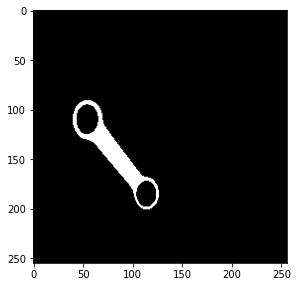

Image:  TESI92.BMP
Connecting rod dimension:  (178.6184844970703, 44.84672927856445)


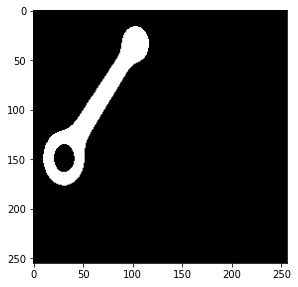

Connecting rod dimension:  (109.79297637939453, 38.36627197265625)


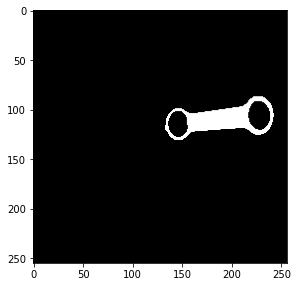

Connecting rod dimension:  (147.0, 54.0)


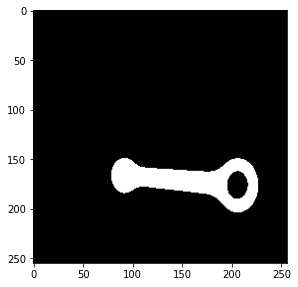

Image:  TESI98.BMP
Connecting rod dimension:  (181.2332763671875, 44.11282730102539)


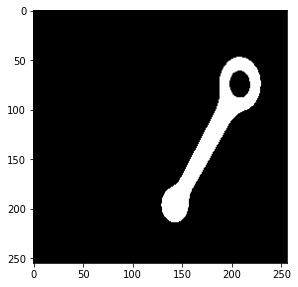

Connecting rod dimension:  (116.9709243774414, 37.03181457519531)


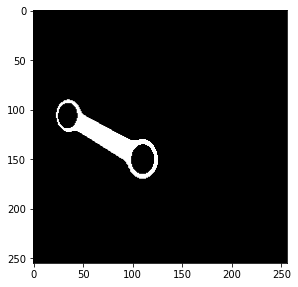

In [14]:
connecting_rods_dimension = compute_connecting_rods_dimension(connecting_rods_contours)
show_connected_components(labeled_images, labels, input_images_name, connecting_rods_dimension, "Dimensions (width and length)", 
                          "Connecting rod dimension: ")

### Connecting rodes width at the barycentre

Image n. 0
Connecting rod n. 0
Width at the barycentre:  15.652475842498529


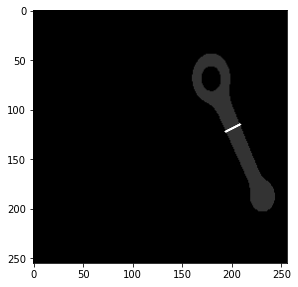

Connecting rod n. 1
Width at the barycentre:  13.038404810405298


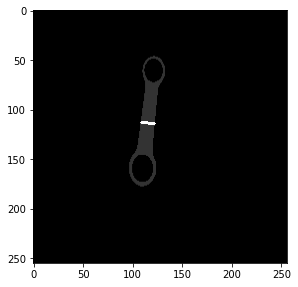

Connecting rod n. 2
Width at the barycentre:  14.035668847618199


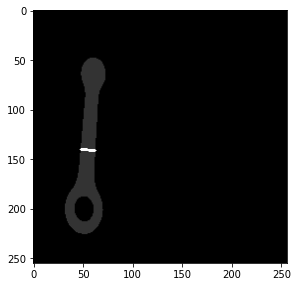

Image n. 1
Connecting rod n. 0
Width at the barycentre:  15.231546211727817


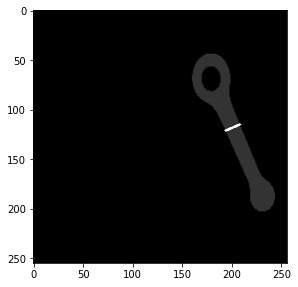

Connecting rod n. 1
Width at the barycentre:  13.038404810405298


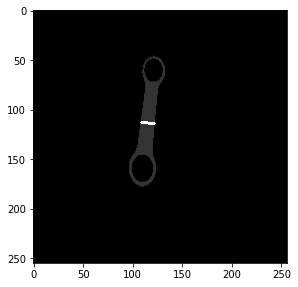

Connecting rod n. 2
Width at the barycentre:  14.035668847618199


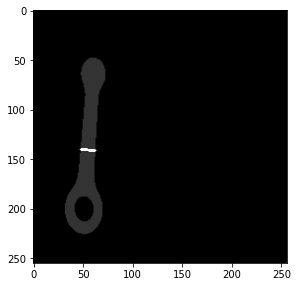

Image n. 2
Connecting rod n. 0
Width at the barycentre:  16.97056274847714


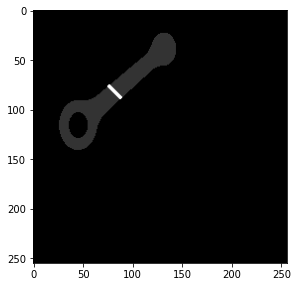

Connecting rod n. 1
Width at the barycentre:  18.027756377319946


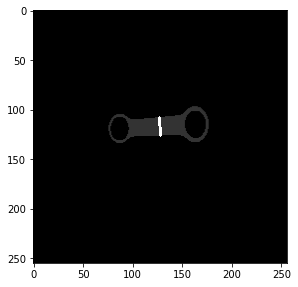

Connecting rod n. 2
Width at the barycentre:  19.1049731745428


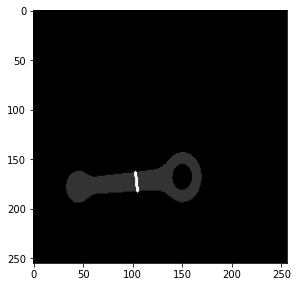

Image n. 3
Connecting rod n. 0
Width at the barycentre:  17.88854381999832


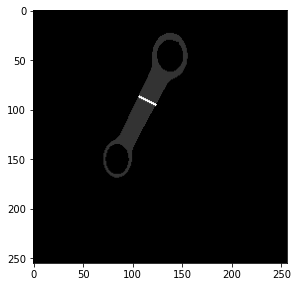

Connecting rod n. 1
Width at the barycentre:  21.2602916254693


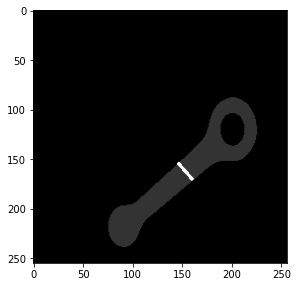

Image n. 4
Connecting rod n. 0
Width at the barycentre:  19.72308292331602


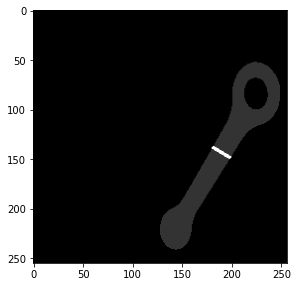

Connecting rod n. 1
Width at the barycentre:  23.021728866442675


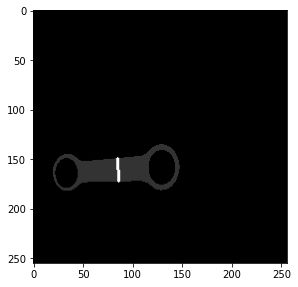

Image n. 5
Connecting rod n. 0
Width at the barycentre:  21.213203435596427


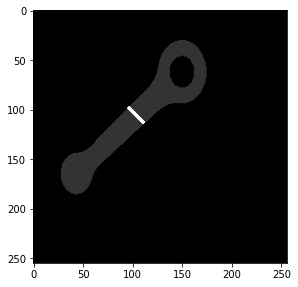

Connecting rod n. 1
Width at the barycentre:  22.20360331117452


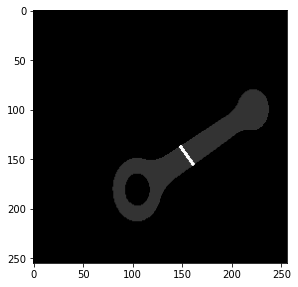

Image n. 6
Connecting rod n. 0
Width at the barycentre:  21.633307652783937


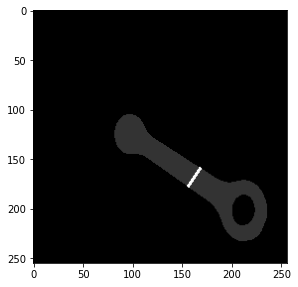

Image n. 7
Connecting rod n. 0
Width at the barycentre:  20.518284528683193


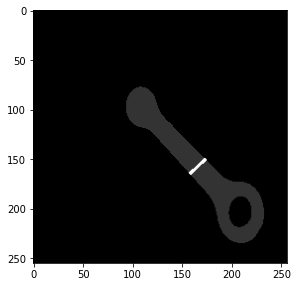

Connecting rod n. 1
Width at the barycentre:  21.02379604162864


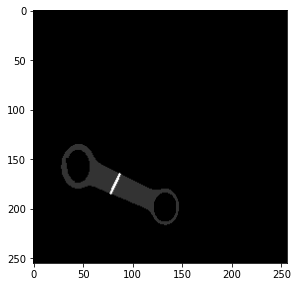

Image n. 8
Connecting rod n. 0
Width at the barycentre:  19.849433241279208


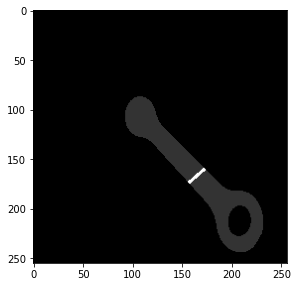

Connecting rod n. 1
Width at the barycentre:  21.02379604162864


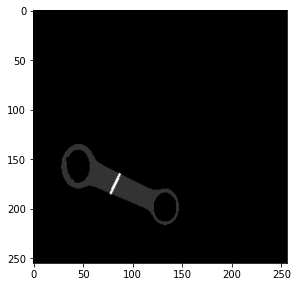

Image n. 9
Connecting rod n. 0
Width at the barycentre:  21.02379604162864


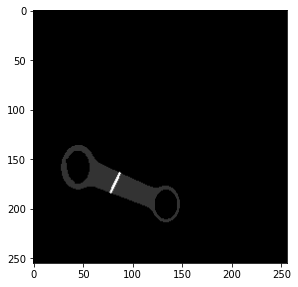

Image n. 10
Connecting rod n. 0
Width at the barycentre:  19.1049731745428


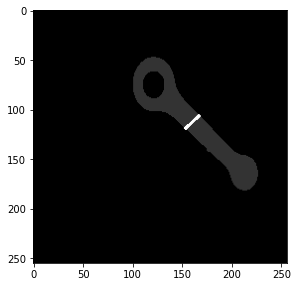

Connecting rod n. 1
Width at the barycentre:  16.401219466856727


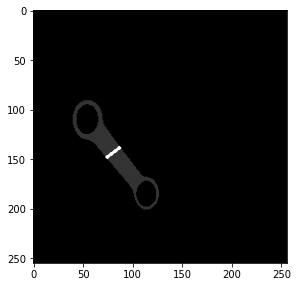

Image n. 11
Connecting rod n. 0
Width at the barycentre:  17.4928556845359


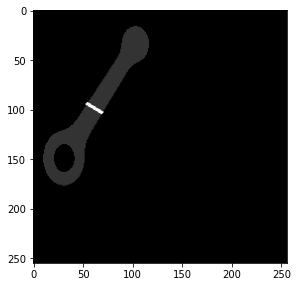

Connecting rod n. 1
Width at the barycentre:  19.1049731745428


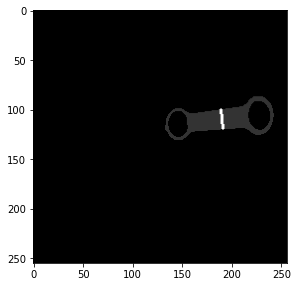

Connecting rod n. 2
Width at the barycentre:  20.09975124224178


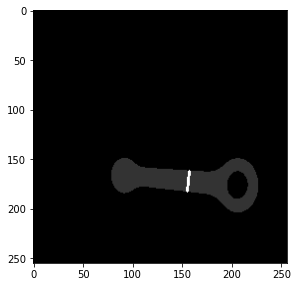

Image n. 12
Connecting rod n. 0
Width at the barycentre:  15.652475842498529


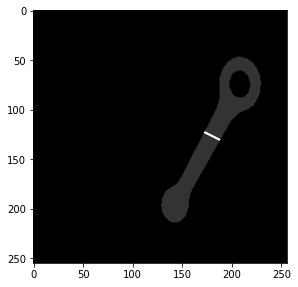

Connecting rod n. 1
Width at the barycentre:  18.35755975068582


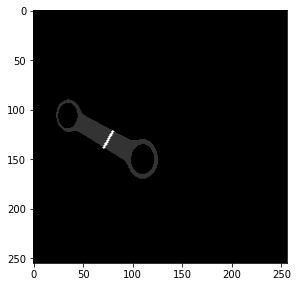

In [15]:
connecting_rods_width_at_the_barycentre = compute_connecting_rods_width_at_barycentre(labeled_images, 
                                                labels, connecting_rods_dimension, items_centroids, 
                                                connecting_rods_orientation, verbose=True)
# Uncomment this to show this measure simialrly to the others (it doesn't show the line that crosses the barycenter)
# show_connected_components(labeled_images, labels, input_images_name, connecting_rods_width_at_the_barycenter, "Widths at the barycenter", 
#                           "Connecting rod width at the barycenter: ")

## 4. Connecting rodes' holes insepection
The last step consists in extracting information about the connecting rods' holes, in particular the coordinates of the centre of the holes and their diameters.
The procedure previuosly used for the contour extractions returns all the contours of each connecting rods, including their inner contours which are, in other terms, the contours of the holes. The contours of the holes will be leveraged in the implementation of this feature.

The coordinates of the centre are computed as the average of the coordinates of the contour.

The diameter is calculated in 2 ways:
1. the first method requires to compute the perimeter (i.e. the length of the contour). Given the perimeter the diameter can be easily determined with the formula of the perimeter of a cirle.
2. the second method instead consists in computing the average of the distance between the centre respect to the contour points

These two methods give different values, wehere the one computed with the first method is always higher than the second.

Connecting rods' holes properties (centre and diameter)
Image:  TESI00.BMP
Holes property:  [{'centre': (179, 68), 'diameter': (24.43650735708666, 23.121336135234124)}]


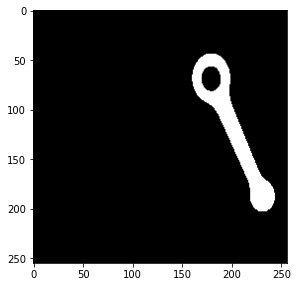

Holes property:  [{'centre': (109, 158), 'diameter': (26.61006320257067, 25.281918254404093)}, {'centre': (121, 60), 'diameter': (23.426964340732763, 21.83208371577671)}]


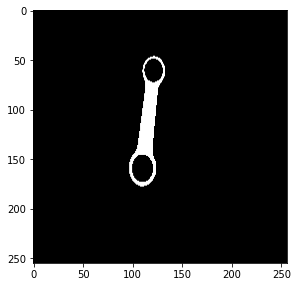

Holes property:  [{'centre': (50, 199), 'diameter': (24.43650735708666, 23.220605664736862)}]


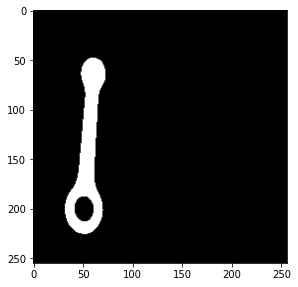

Image:  TESI01.BMP
Holes property:  [{'centre': (178, 68), 'diameter': (24.43650735708666, 23.11086959545617)}]


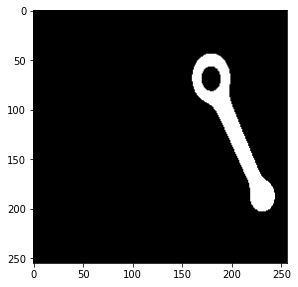

Holes property:  [{'centre': (109, 158), 'diameter': (26.61006320257067, 25.30751469363945)}, {'centre': (121, 60), 'diameter': (23.163267812351496, 21.706277077010313)}]


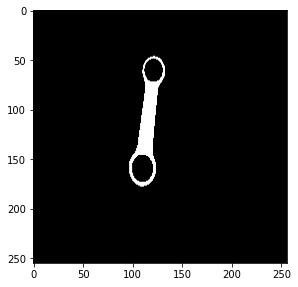

Holes property:  [{'centre': (50, 199), 'diameter': (24.43650735708666, 23.167179537245712)}]


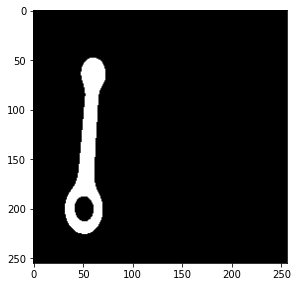

Image:  TESI12.BMP
Holes property:  [{'centre': (45, 115), 'diameter': (24.70020388546793, 23.2846278950529)}]


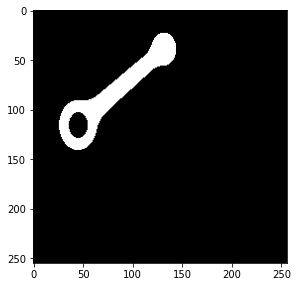

Holes property:  [{'centre': (86, 119), 'diameter': (23.53619105633781, 21.974080875751035)}, {'centre': (163, 114), 'diameter': (26.423601580577515, 25.122127691973727)}]


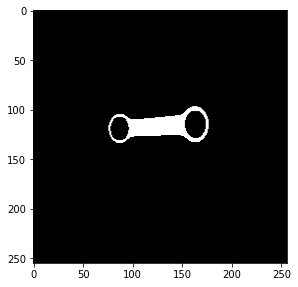

Holes property:  [{'centre': (149, 167), 'diameter': (25.150362035842353, 23.709198495135134)}]


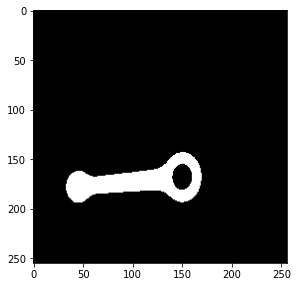

Image:  TESI21.BMP
Holes property:  [{'centre': (84, 149), 'diameter': (29.497473726810373, 27.572970655571865)}, {'centre': (137, 45), 'diameter': (31.857491194287544, 30.070808512176267)}]


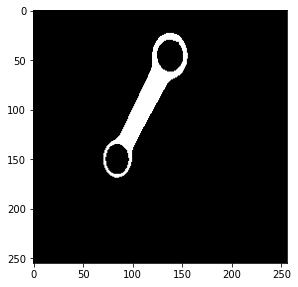

Holes property:  [{'centre': (200, 119), 'diameter': (31.220871421919963, 29.225695822064388)}]


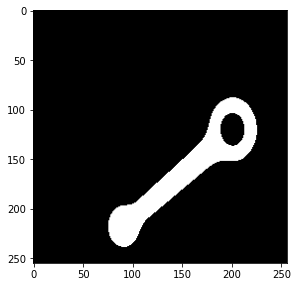

Image:  TESI31.BMP
Holes property:  [{'centre': (224, 83), 'diameter': (30.77071327154554, 28.67755801953589)}]


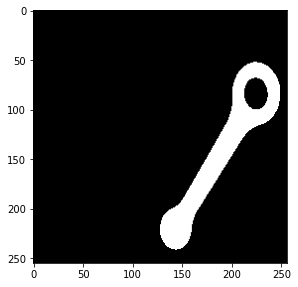

Holes property:  [{'centre': (33, 163), 'diameter': (29.04731557643595, 27.137299156942237)}, {'centre': (129, 157), 'diameter': (33.39442726740397, 31.500996382152763)}]


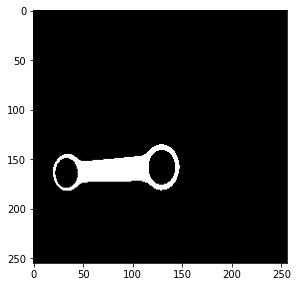

Image:  Tesi33.bmp
Holes property:  [{'centre': (149, 61), 'diameter': (30.77071327154554, 29.018293577599646)}]


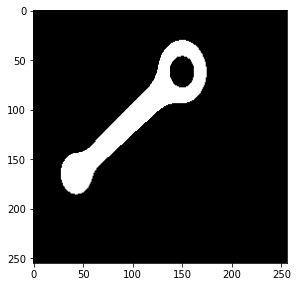

Holes property:  [{'centre': (104, 180), 'diameter': (31.220871421919963, 29.429911943588316)}]


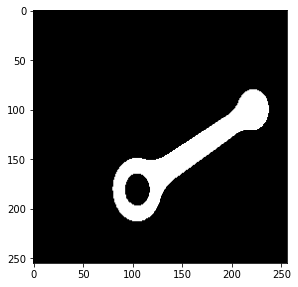

Image:  TESI44.BMP
Holes property:  [{'centre': (211, 201), 'diameter': (29.68393534880353, 27.72302033736178)}]


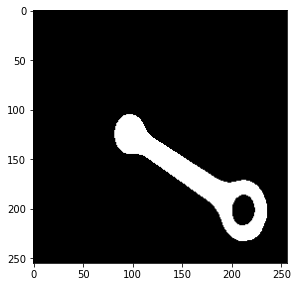

Image:  TESI47.BMP
Holes property:  [{'centre': (208, 202), 'diameter': (29.68393534880353, 27.771378816198073)}]


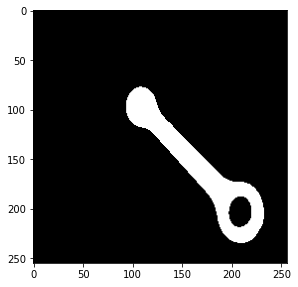

Holes property:  [{'centre': (132, 198), 'diameter': (28.333460897680258, 26.85117092620839)}, {'centre': (44, 156), 'diameter': (31.593794665906277, 28.905001782592567)}]


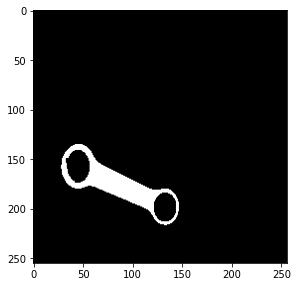

Image:  TESI48.BMP
Holes property:  [{'centre': (207, 212), 'diameter': (29.68393534880353, 27.699659336685936)}]


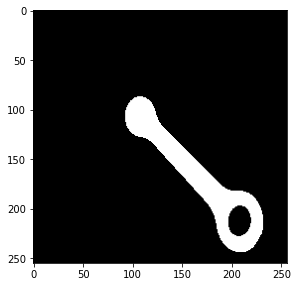

Holes property:  [{'centre': (132, 198), 'diameter': (28.1469992756871, 26.802938741151976)}, {'centre': (45, 156), 'diameter': (31.40733304391312, 28.868636793237183)}]


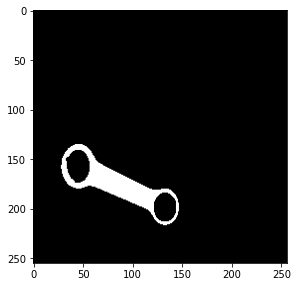

Image:  TESI49.BMP
Holes property:  [{'centre': (133, 195), 'diameter': (28.410695804068368, 26.93670939452406)}, {'centre': (44, 157), 'diameter': (31.220871421919963, 28.756800662760437)}]


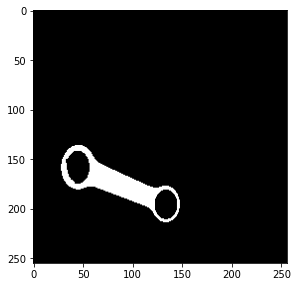

Image:  TESI90.BMP
Holes property:  [{'centre': (121, 74), 'diameter': (26.61006320257067, 25.335132491143877)}]


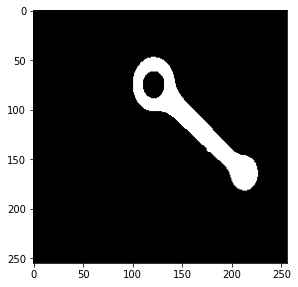

Holes property:  [{'centre': (113, 184), 'diameter': (25.150362035842353, 23.844703792858684)}, {'centre': (54, 109), 'diameter': (28.597157426061525, 26.740062831685652)}]


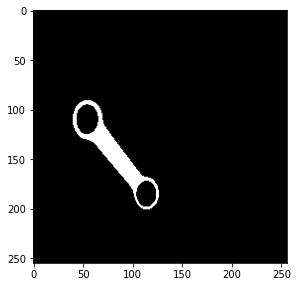

Image:  TESI92.BMP
Holes property:  [{'centre': (30, 148), 'diameter': (26.68729810895878, 25.086314703954233)}]


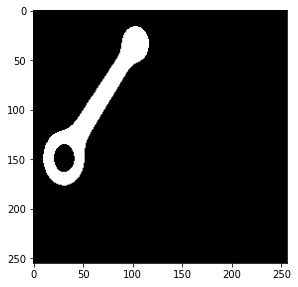

Holes property:  [{'centre': (145, 114), 'diameter': (25.150362035842353, 23.61873080980158)}, {'centre': (227, 105), 'diameter': (27.774076031700787, 26.212794791004978)}]


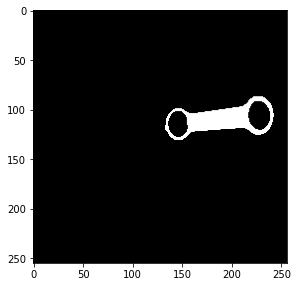

Holes property:  [{'centre': (205, 175), 'diameter': (26.68729810895878, 25.07311258617758)}]


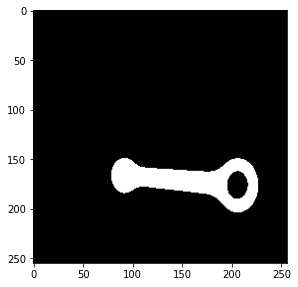

Image:  TESI98.BMP
Holes property:  [{'centre': (208, 74), 'diameter': (26.423601580577515, 24.848879943001364)}]


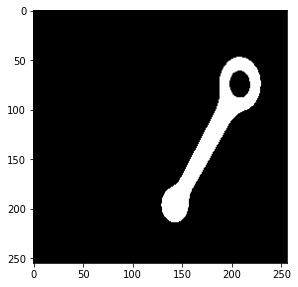

Holes property:  [{'centre': (110, 149), 'diameter': (28.860853954442792, 27.286035480344193)}, {'centre': (34, 105), 'diameter': (24.70020388546793, 23.3691930025506)}]


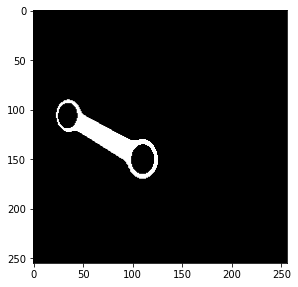

In [16]:
connecting_rods_holes_propety = compute_connecting_rods_holes_properties(connecting_rods_contours)
show_connected_components(labeled_images, labels, input_images_name, connecting_rods_holes_propety, "Connecting rods' holes properties (centre and diameter)", 
                          "Holes property: ")